In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 2
2023-07-28 15:06:47.075815


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-12.9182)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(8.5986)
penalty_target_min tensor(-11.6229) penalty_target_max tensor(5.3304)
train_loss:  -8.42597192583084
valid_loss:  -8.129956848144532
h_min_tilde -11.622948 ell_tilde -8.366768910293578 kappa_tilde 0.0005541736588958331


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.430511474609375e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.97835373878479

 2 4.561374187469482

 3 4.4018003940582275

 4 4.49869966506958

 5 4.538697004318237

 6 4.384462594985962

 7 4.404864311218262

 8 5.054562091827393

 9 4.633575439453125

 10 4.623121976852417

 11 5.982738256454468

 12 4.322115659713745

 13 4.26899266242981

 14 4.367602586746216

 15 4.433669328689575

 16 7.142285346984863

 17 9.148695945739746

 18 8.699650049209595

 19 8.177223205566406

 20 9.02286982536316

 21 9.09201169013977

 22 7.501272916793823

 23 4.712913751602173

 24 4.567758560180664

 25 5.436643600463867

 26 8.95166563987732

 27 8.420100927352905

 28 9.09420108795166

 29 8.742411375045776

 30 4.20976185798645

 31 4.29255485534668

 32 4.7162864208221436

 33 4.786129474639893

 34 4.359824180603027

 35 4.731237173080444

 36 8.491806745529175

 37 5.095464468002319

 38 4.602989435195923

 39 4.310299396514893

 40 4.295016765594482

 41 4.406798362731934

 42 4.318458557128906

 43 4.276871681213379

 44 4.427192687988281

 45

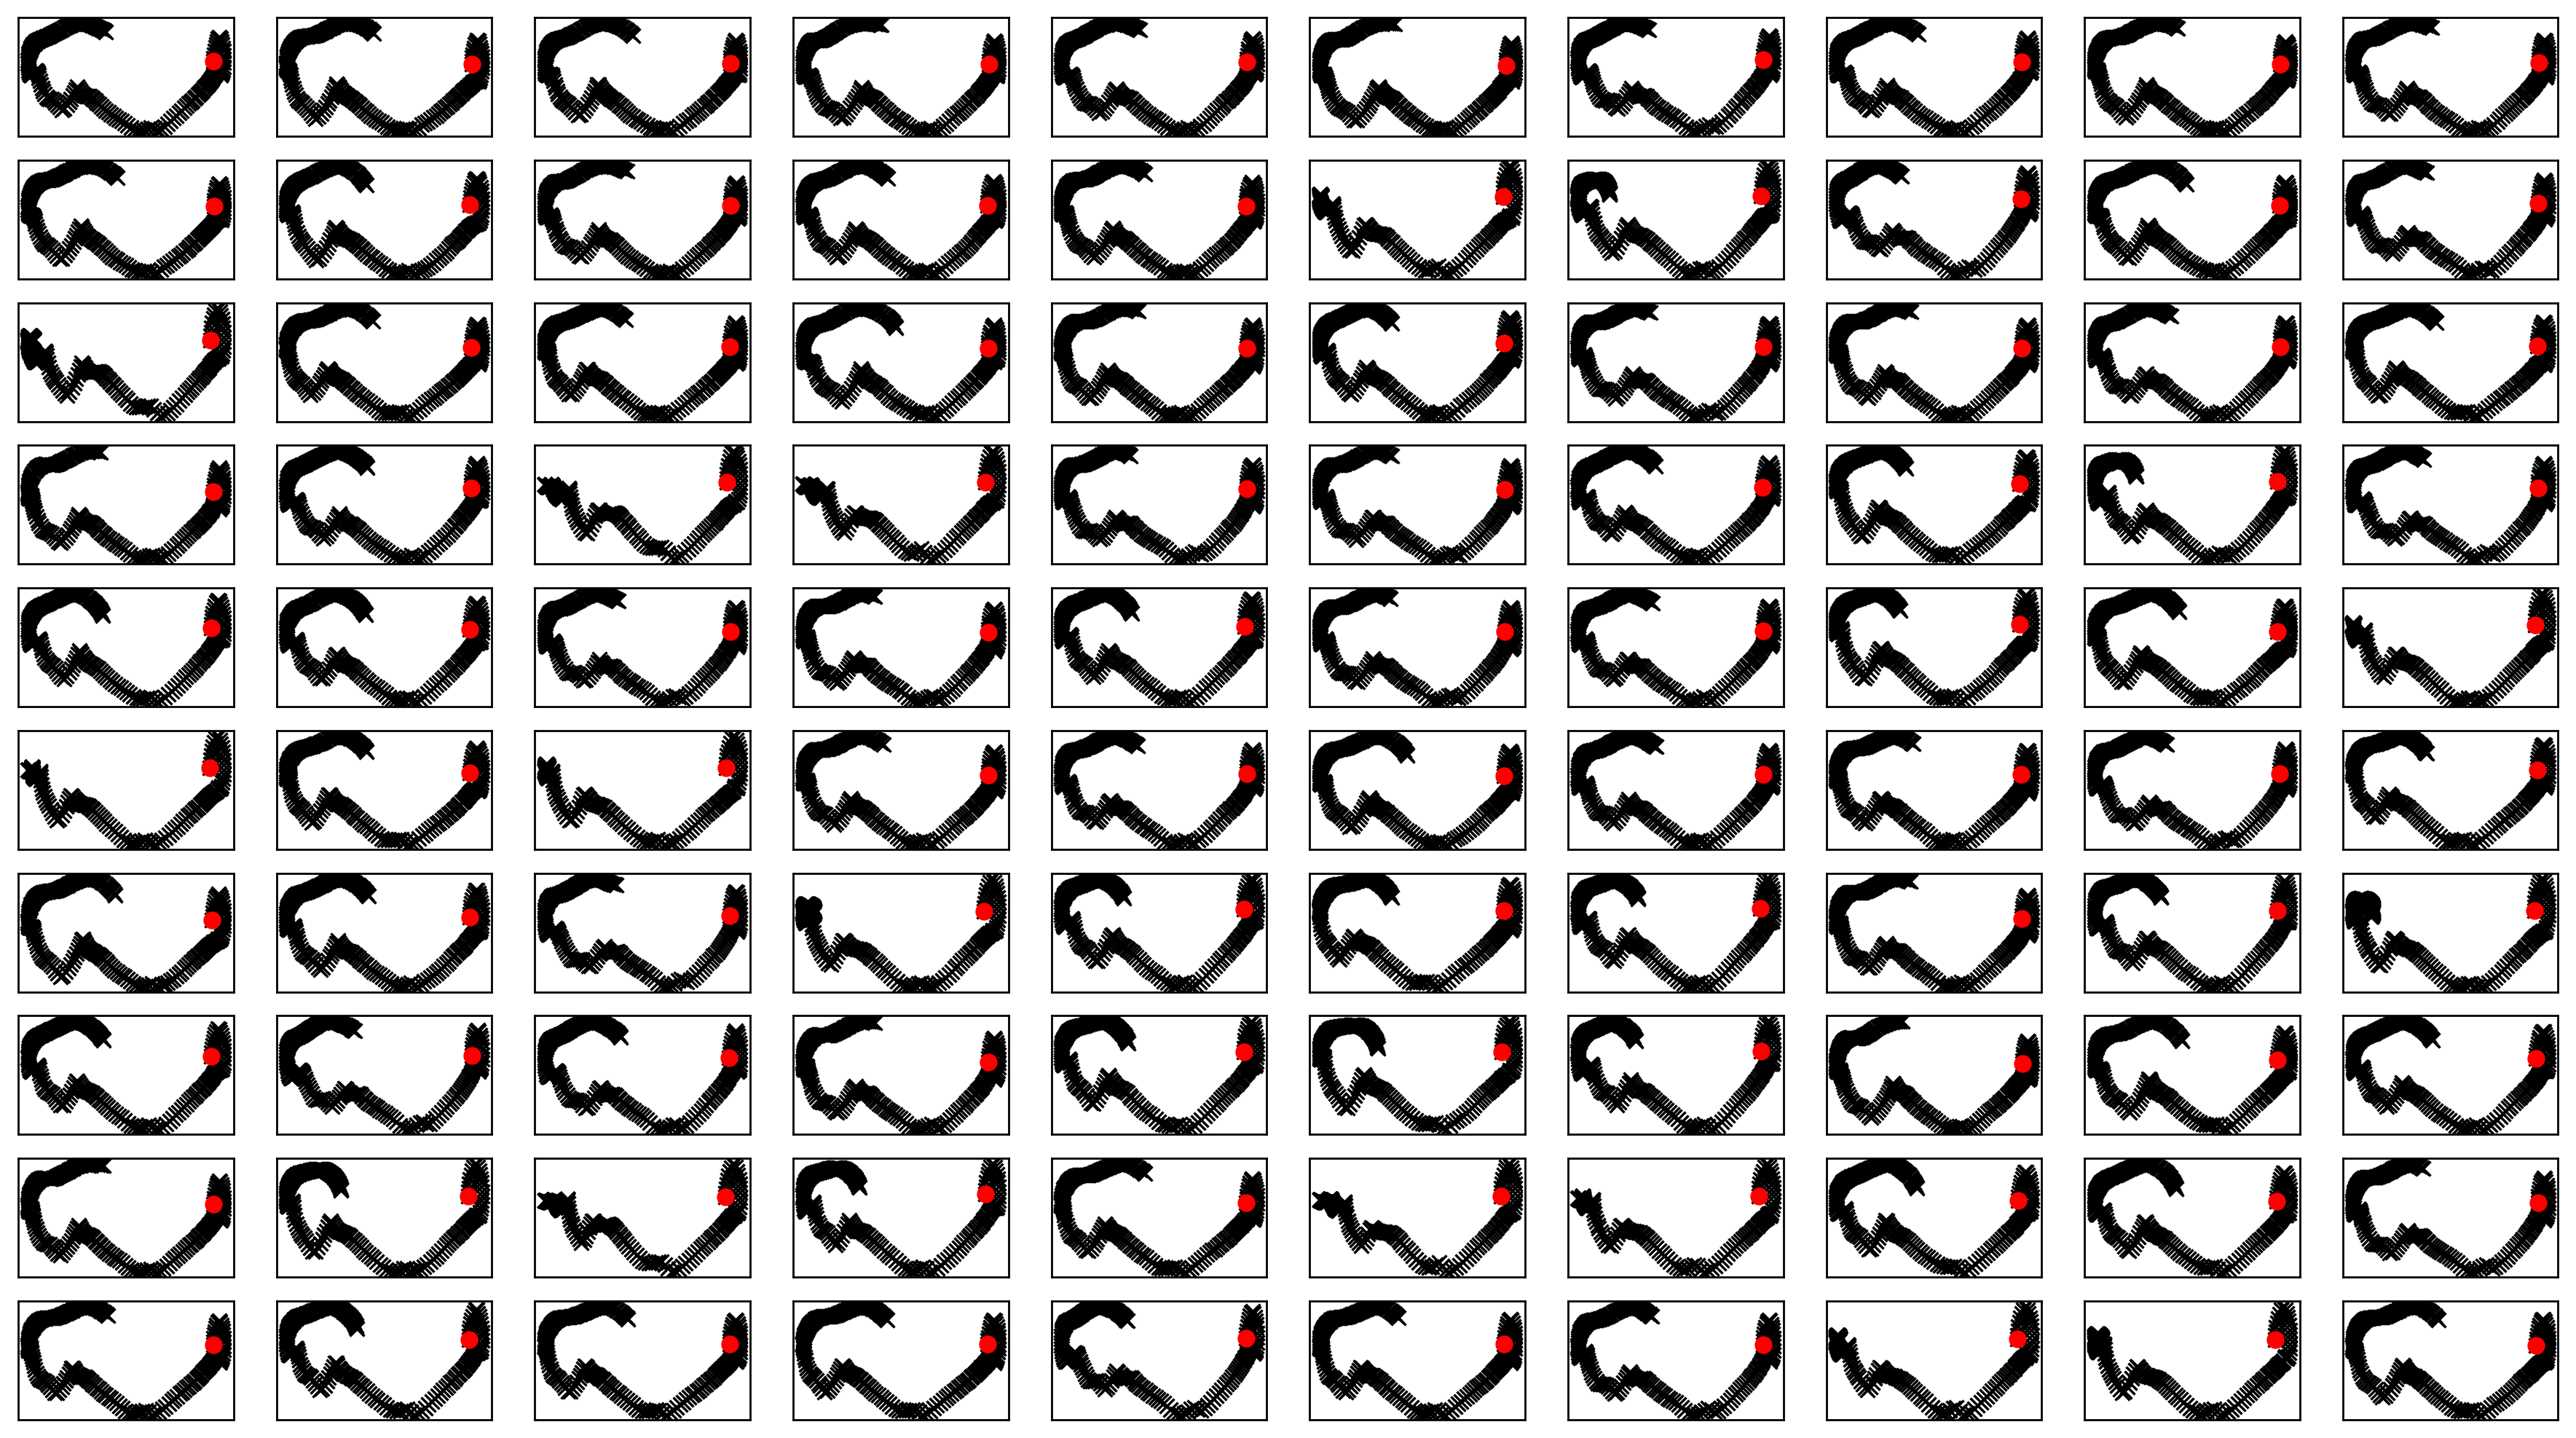

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

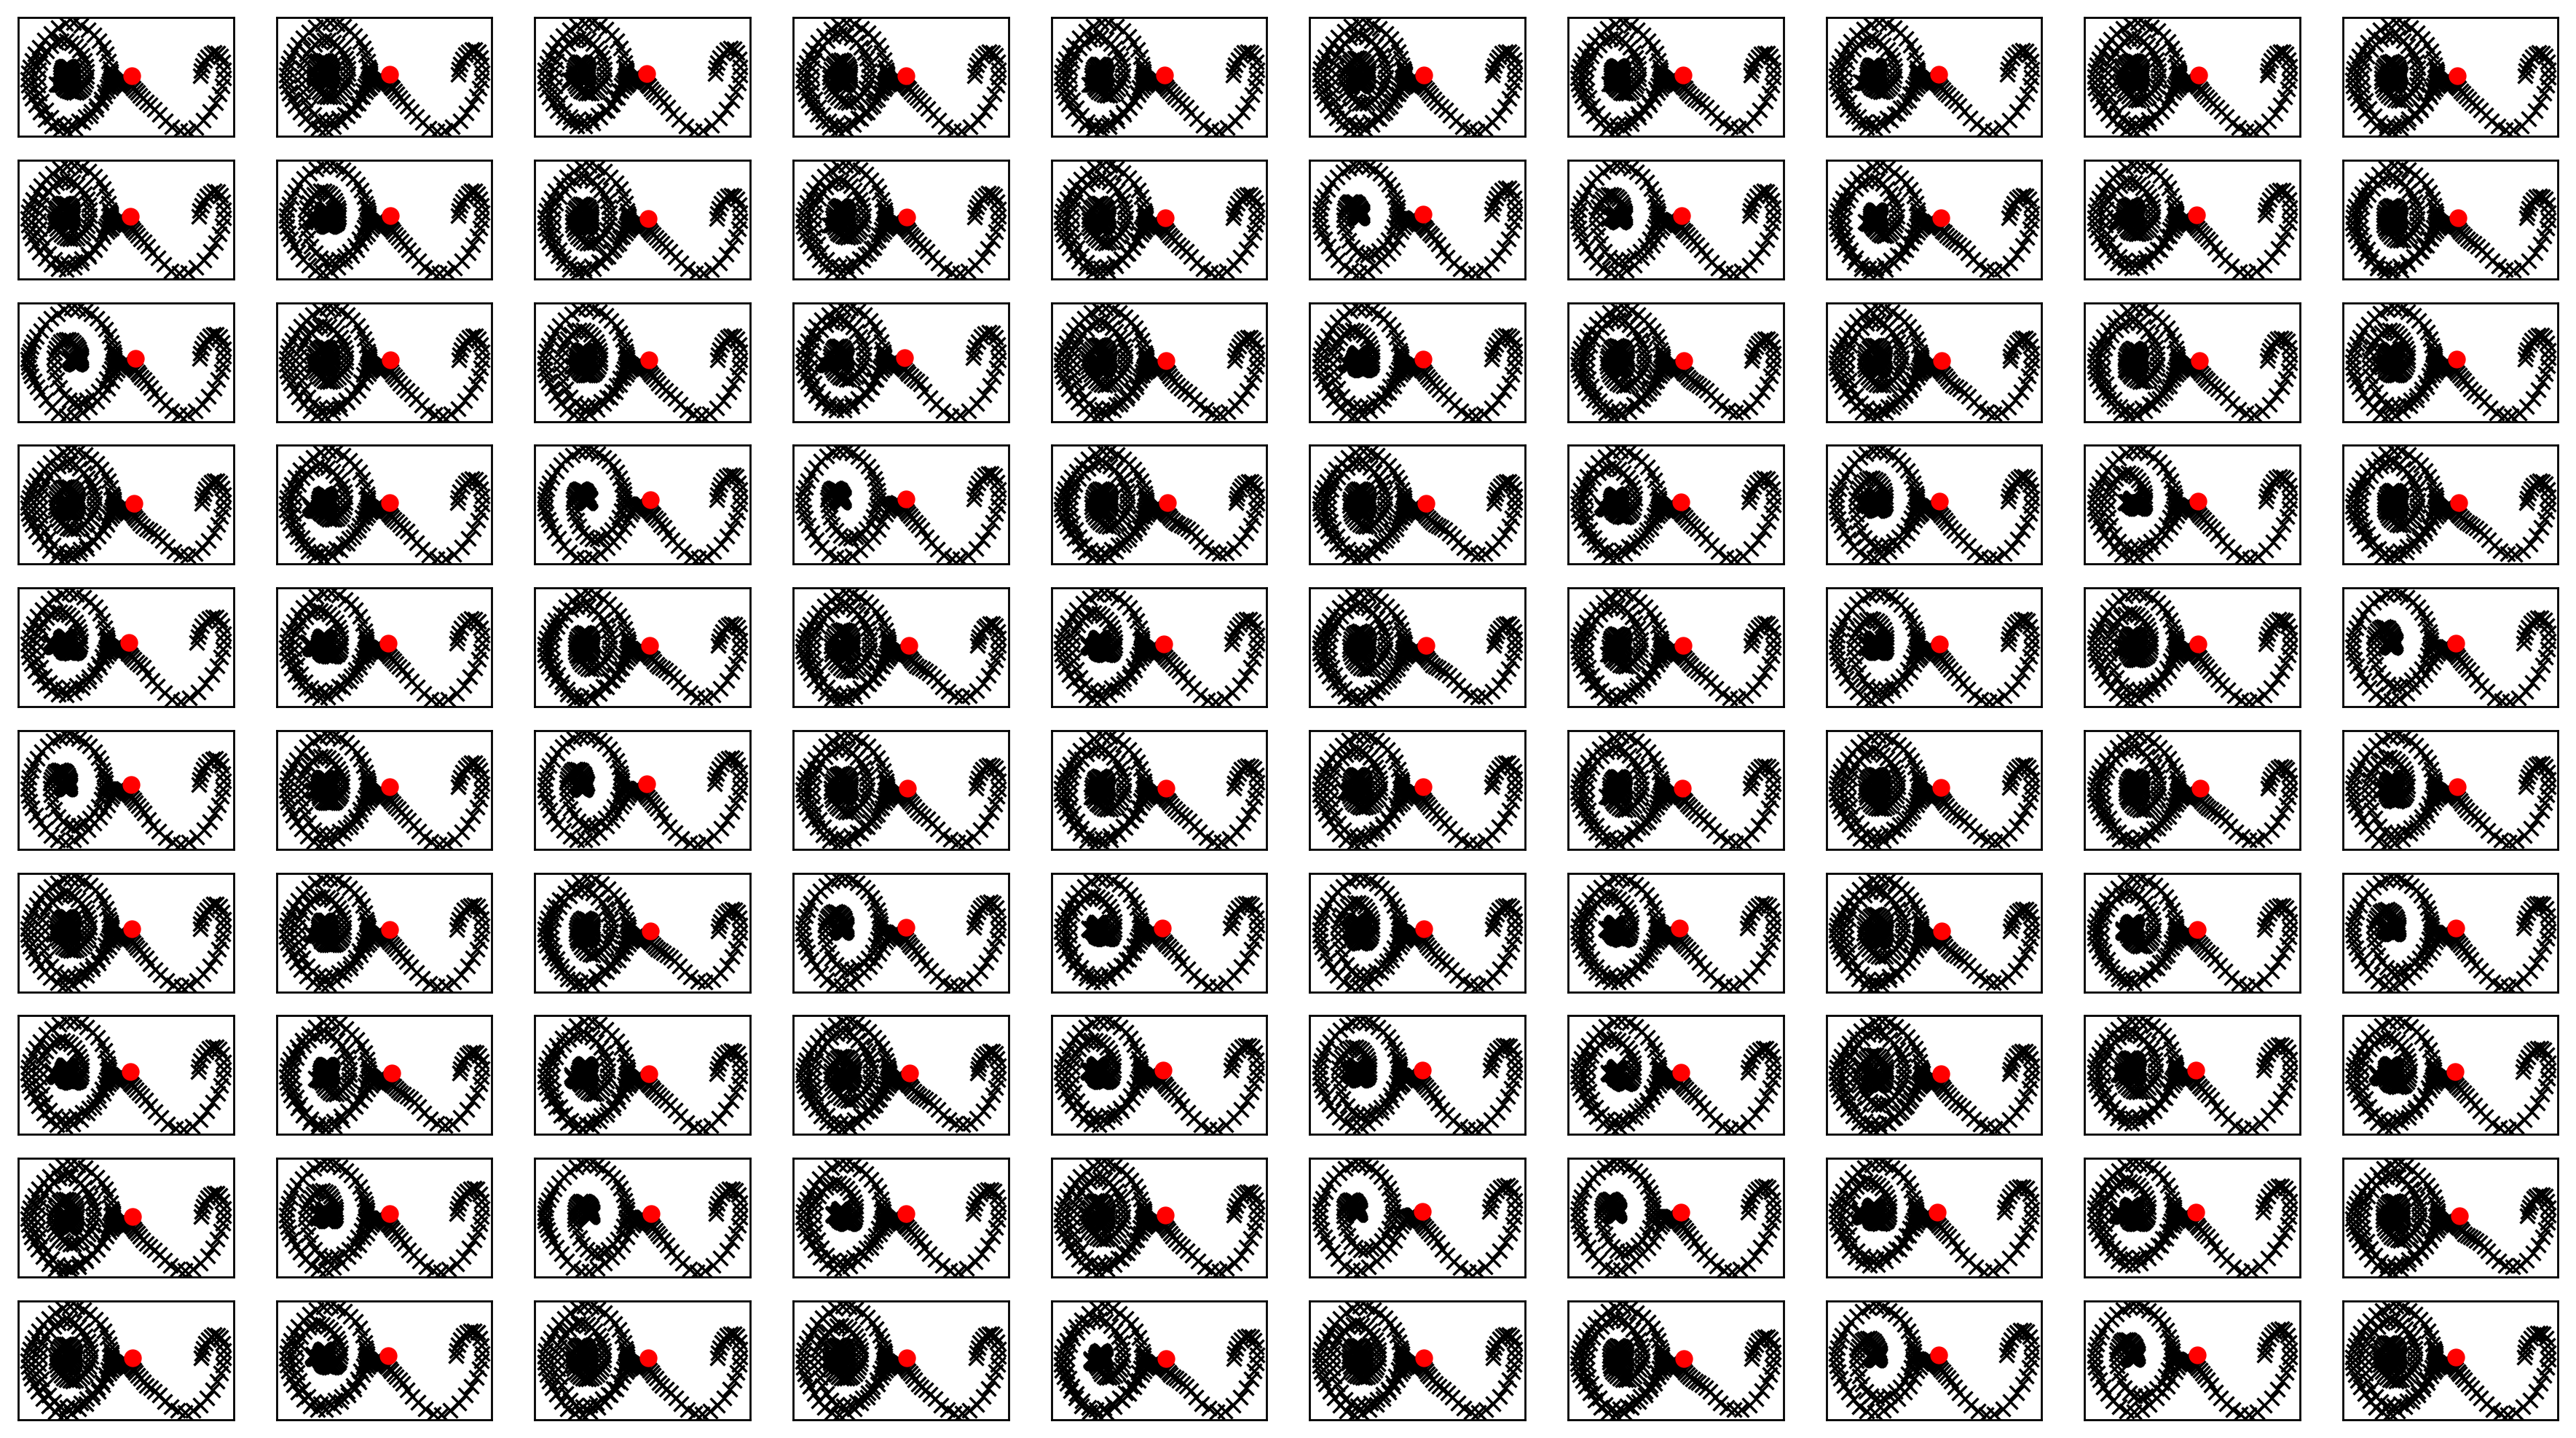

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-28 15:15:24.540107


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.34426  validloss 1.42772±0.00000  bestvalidloss 1.42772  last_update 0
train: iter 1  trainloss 1.22851  validloss 1.26889±0.00000  bestvalidloss 1.26889  last_update 0
train: iter 2  trainloss 1.13120  validloss 1.15217±0.00000  bestvalidloss 1.15217  last_update 0
train: iter 3  trainloss 1.03828  validloss 1.04732±0.00000  bestvalidloss 1.04732  last_update 0
train: iter 4  trainloss 0.96863  validloss 0.95937±0.00000  bestvalidloss 0.95937  last_update 0
train: iter 5  trainloss 0.89898  validloss 0.89773±0.00000  bestvalidloss 0.89773  last_update 0
train: iter 6  trainloss 0.83717  validloss 0.81876±0.00000  bestvalidloss 0.81876  last_update 0
train: iter 7  trainloss 0.78598  validloss 0.77304±0.00000  bestvalidloss 0.77304  last_update 0
train: iter 8  trainloss 0.74008  validloss 0.72449±0.00000  bestvalidloss 0.72449  last_update 0
train: iter 9  trainloss 0.70119  validloss 0.67530±0.00000  bestvalidloss 0.67530  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.40411  validloss 0.41815±0.00000  bestvalidloss 0.39743  last_update 2
train: iter 84  trainloss 0.39148  validloss 0.40235±0.00000  bestvalidloss 0.39743  last_update 3
train: iter 85  trainloss 0.38922  validloss 0.39931±0.00000  bestvalidloss 0.39743  last_update 4
train: iter 86  trainloss 0.39436  validloss 0.44100±0.00000  bestvalidloss 0.39743  last_update 5
train: iter 87  trainloss 0.39513  validloss 0.39568±0.00000  bestvalidloss 0.39568  last_update 0
train: iter 88  trainloss 0.38928  validloss 0.40876±0.00000  bestvalidloss 0.39568  last_update 1
train: iter 89  trainloss 0.39221  validloss 0.41216±0.00000  bestvalidloss 0.39568  last_update 2
train: iter 90  trainloss 0.39007  validloss 0.40307±0.00000  bestvalidloss 0.39568  last_update 3
train: iter 91  trainloss 0.38899  validloss 0.40617±0.00000  bestvalidloss 0.39568  last_update 4
train: iter 92  trainloss 0.39093  validloss 0.38576±0.00000  bestvalidloss 0.38576  last_update 0
train: ite

train: iter 166  trainloss 0.36697  validloss 0.38511±0.00000  bestvalidloss 0.36325  last_update 7
train: iter 167  trainloss 0.36410  validloss 0.38125±0.00000  bestvalidloss 0.36325  last_update 8
train: iter 168  trainloss 0.36096  validloss 0.36323±0.00000  bestvalidloss 0.36323  last_update 0
train: iter 169  trainloss 0.35972  validloss 0.39682±0.00000  bestvalidloss 0.36323  last_update 1
train: iter 170  trainloss 0.35535  validloss 0.36879±0.00000  bestvalidloss 0.36323  last_update 2
train: iter 171  trainloss 0.35844  validloss 0.38978±0.00000  bestvalidloss 0.36323  last_update 3
train: iter 172  trainloss 0.36384  validloss 0.39005±0.00000  bestvalidloss 0.36323  last_update 4
train: iter 173  trainloss 0.36317  validloss 0.37742±0.00000  bestvalidloss 0.36323  last_update 5
train: iter 174  trainloss 0.35906  validloss 0.38641±0.00000  bestvalidloss 0.36323  last_update 6
train: iter 175  trainloss 0.35673  validloss 0.37497±0.00000  bestvalidloss 0.36323  last_update 7


train: iter 248  trainloss 0.34370  validloss 0.37137±0.00000  bestvalidloss 0.35040  last_update 30
train: iter 249  trainloss 0.34287  validloss 0.36129±0.00000  bestvalidloss 0.35040  last_update 31
train: iter 250  trainloss 0.34267  validloss 0.34932±0.00000  bestvalidloss 0.34932  last_update 0
train: iter 251  trainloss 0.33855  validloss 0.35956±0.00000  bestvalidloss 0.34932  last_update 1
train: iter 252  trainloss 0.33942  validloss 0.39675±0.00000  bestvalidloss 0.34932  last_update 2
train: iter 253  trainloss 0.34647  validloss 0.35996±0.00000  bestvalidloss 0.34932  last_update 3
train: iter 254  trainloss 0.33988  validloss 0.36825±0.00000  bestvalidloss 0.34932  last_update 4
train: iter 255  trainloss 0.33923  validloss 0.35086±0.00000  bestvalidloss 0.34932  last_update 5
train: iter 256  trainloss 0.34559  validloss 0.41059±0.00000  bestvalidloss 0.34932  last_update 6
train: iter 257  trainloss 0.34240  validloss 0.37069±0.00000  bestvalidloss 0.34932  last_update 

train: iter 330  trainloss 0.32555  validloss 0.34342±0.00000  bestvalidloss 0.34080  last_update 7
train: iter 331  trainloss 0.31891  validloss 0.35260±0.00000  bestvalidloss 0.34080  last_update 8
train: iter 332  trainloss 0.31878  validloss 0.34541±0.00000  bestvalidloss 0.34080  last_update 9
train: iter 333  trainloss 0.32532  validloss 0.39725±0.00000  bestvalidloss 0.34080  last_update 10
train: iter 334  trainloss 0.31805  validloss 0.34954±0.00000  bestvalidloss 0.34080  last_update 11
train: iter 335  trainloss 0.32281  validloss 0.34934±0.00000  bestvalidloss 0.34080  last_update 12
train: iter 336  trainloss 0.32435  validloss 0.38140±0.00000  bestvalidloss 0.34080  last_update 13
train: iter 337  trainloss 0.32565  validloss 0.35115±0.00000  bestvalidloss 0.34080  last_update 14
train: iter 338  trainloss 0.32564  validloss 0.35520±0.00000  bestvalidloss 0.34080  last_update 15
train: iter 339  trainloss 0.31876  validloss 0.35294±0.00000  bestvalidloss 0.34080  last_upd

train: iter 412  trainloss 0.31158  validloss 0.35452±0.00000  bestvalidloss 0.33229  last_update 41
train: iter 413  trainloss 0.30723  validloss 0.33585±0.00000  bestvalidloss 0.33229  last_update 42
train: iter 414  trainloss 0.30855  validloss 0.34651±0.00000  bestvalidloss 0.33229  last_update 43
train: iter 415  trainloss 0.30676  validloss 0.33302±0.00000  bestvalidloss 0.33229  last_update 44
train: iter 416  trainloss 0.31144  validloss 0.38832±0.00000  bestvalidloss 0.33229  last_update 45
train: iter 417  trainloss 0.31338  validloss 0.33198±0.00000  bestvalidloss 0.33198  last_update 0
train: iter 418  trainloss 0.30622  validloss 0.33142±0.00000  bestvalidloss 0.33142  last_update 0
train: iter 419  trainloss 0.30836  validloss 0.33033±0.00000  bestvalidloss 0.33033  last_update 0
train: iter 420  trainloss 0.31000  validloss 0.33718±0.00000  bestvalidloss 0.33033  last_update 1
train: iter 421  trainloss 0.30433  validloss 0.34021±0.00000  bestvalidloss 0.33033  last_upda

train: iter 494  trainloss 0.29846  validloss 0.33064±0.00000  bestvalidloss 0.32707  last_update 33
train: iter 495  trainloss 0.29512  validloss 0.33757±0.00000  bestvalidloss 0.32707  last_update 34
train: iter 496  trainloss 0.29482  validloss 0.34529±0.00000  bestvalidloss 0.32707  last_update 35
train: iter 497  trainloss 0.29627  validloss 0.35001±0.00000  bestvalidloss 0.32707  last_update 36
train: iter 498  trainloss 0.29542  validloss 0.34372±0.00000  bestvalidloss 0.32707  last_update 37
train: iter 499  trainloss 0.29385  validloss 0.34320±0.00000  bestvalidloss 0.32707  last_update 38
train: iter 500  trainloss 0.28971  validloss 0.32996±0.00000  bestvalidloss 0.32707  last_update 39
train: iter 501  trainloss 0.29315  validloss 0.33876±0.00000  bestvalidloss 0.32707  last_update 40
train: iter 502  trainloss 0.29603  validloss 0.33500±0.00000  bestvalidloss 0.32707  last_update 41
train: iter 503  trainloss 0.29168  validloss 0.33414±0.00000  bestvalidloss 0.32707  last_

train: iter 576  trainloss 0.28490  validloss 0.33752±0.00000  bestvalidloss 0.32537  last_update 43
train: iter 577  trainloss 0.29129  validloss 0.32459±0.00000  bestvalidloss 0.32459  last_update 0
train: iter 578  trainloss 0.28612  validloss 0.33580±0.00000  bestvalidloss 0.32459  last_update 1
train: iter 579  trainloss 0.28812  validloss 0.32881±0.00000  bestvalidloss 0.32459  last_update 2
train: iter 580  trainloss 0.28172  validloss 0.33387±0.00000  bestvalidloss 0.32459  last_update 3
train: iter 581  trainloss 0.28787  validloss 0.33767±0.00000  bestvalidloss 0.32459  last_update 4
train: iter 582  trainloss 0.28160  validloss 0.34141±0.00000  bestvalidloss 0.32459  last_update 5
train: iter 583  trainloss 0.27951  validloss 0.34012±0.00000  bestvalidloss 0.32459  last_update 6
train: iter 584  trainloss 0.28521  validloss 0.34462±0.00000  bestvalidloss 0.32459  last_update 7
train: iter 585  trainloss 0.28961  validloss 0.33271±0.00000  bestvalidloss 0.32459  last_update 8

train: iter 658  trainloss 0.27522  validloss 0.33474±0.00000  bestvalidloss 0.31753  last_update 15
train: iter 659  trainloss 0.28128  validloss 0.33227±0.00000  bestvalidloss 0.31753  last_update 16
train: iter 660  trainloss 0.27842  validloss 0.32481±0.00000  bestvalidloss 0.31753  last_update 17
train: iter 661  trainloss 0.27740  validloss 0.31706±0.00000  bestvalidloss 0.31706  last_update 0
train: iter 662  trainloss 0.27638  validloss 0.34299±0.00000  bestvalidloss 0.31706  last_update 1
train: iter 663  trainloss 0.27469  validloss 0.33103±0.00000  bestvalidloss 0.31706  last_update 2
train: iter 664  trainloss 0.27960  validloss 0.33391±0.00000  bestvalidloss 0.31706  last_update 3
train: iter 665  trainloss 0.27412  validloss 0.34090±0.00000  bestvalidloss 0.31706  last_update 4
train: iter 666  trainloss 0.27925  validloss 0.35216±0.00000  bestvalidloss 0.31706  last_update 5
train: iter 667  trainloss 0.27804  validloss 0.32705±0.00000  bestvalidloss 0.31706  last_update

train: iter 740  trainloss 0.27021  validloss 0.32797±0.00000  bestvalidloss 0.30954  last_update 24
train: iter 741  trainloss 0.26858  validloss 0.31910±0.00000  bestvalidloss 0.30954  last_update 25
train: iter 742  trainloss 0.26945  validloss 0.31698±0.00000  bestvalidloss 0.30954  last_update 26
train: iter 743  trainloss 0.26988  validloss 0.31762±0.00000  bestvalidloss 0.30954  last_update 27
train: iter 744  trainloss 0.26747  validloss 0.32026±0.00000  bestvalidloss 0.30954  last_update 28
train: iter 745  trainloss 0.26759  validloss 0.36042±0.00000  bestvalidloss 0.30954  last_update 29
train: iter 746  trainloss 0.26859  validloss 0.32294±0.00000  bestvalidloss 0.30954  last_update 30
train: iter 747  trainloss 0.26961  validloss 0.33476±0.00000  bestvalidloss 0.30954  last_update 31
train: iter 748  trainloss 0.26951  validloss 0.31740±0.00000  bestvalidloss 0.30954  last_update 32
train: iter 749  trainloss 0.26904  validloss 0.32326±0.00000  bestvalidloss 0.30954  last_

train: iter 822  trainloss 0.26407  validloss 0.31372±0.00000  bestvalidloss 0.30631  last_update 42
train: iter 823  trainloss 0.25979  validloss 0.31342±0.00000  bestvalidloss 0.30631  last_update 43
train: iter 824  trainloss 0.25841  validloss 0.32738±0.00000  bestvalidloss 0.30631  last_update 44
train: iter 825  trainloss 0.26614  validloss 0.33065±0.00000  bestvalidloss 0.30631  last_update 45
train: iter 826  trainloss 0.26079  validloss 0.30918±0.00000  bestvalidloss 0.30631  last_update 46
train: iter 827  trainloss 0.26571  validloss 0.30347±0.00000  bestvalidloss 0.30347  last_update 0
train: iter 828  trainloss 0.26067  validloss 0.32449±0.00000  bestvalidloss 0.30347  last_update 1
train: iter 829  trainloss 0.26064  validloss 0.31850±0.00000  bestvalidloss 0.30347  last_update 2
train: iter 830  trainloss 0.26268  validloss 0.31489±0.00000  bestvalidloss 0.30347  last_update 3
train: iter 831  trainloss 0.26470  validloss 0.33002±0.00000  bestvalidloss 0.30347  last_upda

train: iter 904  trainloss 0.25453  validloss 0.30624±0.00000  bestvalidloss 0.30039  last_update 24
train: iter 905  trainloss 0.26050  validloss 0.30989±0.00000  bestvalidloss 0.30039  last_update 25
train: iter 906  trainloss 0.25532  validloss 0.33825±0.00000  bestvalidloss 0.30039  last_update 26
train: iter 907  trainloss 0.25794  validloss 0.31045±0.00000  bestvalidloss 0.30039  last_update 27
train: iter 908  trainloss 0.25152  validloss 0.31655±0.00000  bestvalidloss 0.30039  last_update 28
train: iter 909  trainloss 0.25480  validloss 0.30853±0.00000  bestvalidloss 0.30039  last_update 29
train: iter 910  trainloss 0.25801  validloss 0.34431±0.00000  bestvalidloss 0.30039  last_update 30
train: iter 911  trainloss 0.26138  validloss 0.31621±0.00000  bestvalidloss 0.30039  last_update 31
train: iter 912  trainloss 0.25384  validloss 0.31368±0.00000  bestvalidloss 0.30039  last_update 32
train: iter 913  trainloss 0.25944  validloss 0.31925±0.00000  bestvalidloss 0.30039  last_

train: iter 986  trainloss 0.25088  validloss 0.30550±0.00000  bestvalidloss 0.29941  last_update 26
train: iter 987  trainloss 0.25574  validloss 0.34397±0.00000  bestvalidloss 0.29941  last_update 27
train: iter 988  trainloss 0.25101  validloss 0.30348±0.00000  bestvalidloss 0.29941  last_update 28
train: iter 989  trainloss 0.25166  validloss 0.30764±0.00000  bestvalidloss 0.29941  last_update 29
train: iter 990  trainloss 0.24642  validloss 0.31252±0.00000  bestvalidloss 0.29941  last_update 30
train: iter 991  trainloss 0.25196  validloss 0.31372±0.00000  bestvalidloss 0.29941  last_update 31
train: iter 992  trainloss 0.24856  validloss 0.29964±0.00000  bestvalidloss 0.29941  last_update 32
train: iter 993  trainloss 0.24807  validloss 0.30692±0.00000  bestvalidloss 0.29941  last_update 33
train: iter 994  trainloss 0.24969  validloss 0.30209±0.00000  bestvalidloss 0.29941  last_update 34
train: iter 995  trainloss 0.25017  validloss 0.30156±0.00000  bestvalidloss 0.29941  last_

train: iter 1067  trainloss 0.24375  validloss 0.30151±0.00000  bestvalidloss 0.29508  last_update 9
train: iter 1068  trainloss 0.24273  validloss 0.29527±0.00000  bestvalidloss 0.29508  last_update 10
train: iter 1069  trainloss 0.24219  validloss 0.29876±0.00000  bestvalidloss 0.29508  last_update 11
train: iter 1070  trainloss 0.24163  validloss 0.30891±0.00000  bestvalidloss 0.29508  last_update 12
train: iter 1071  trainloss 0.24251  validloss 0.30068±0.00000  bestvalidloss 0.29508  last_update 13
train: iter 1072  trainloss 0.24257  validloss 0.30369±0.00000  bestvalidloss 0.29508  last_update 14
train: iter 1073  trainloss 0.24194  validloss 0.31336±0.00000  bestvalidloss 0.29508  last_update 15
train: iter 1074  trainloss 0.24175  validloss 0.30138±0.00000  bestvalidloss 0.29508  last_update 16
train: iter 1075  trainloss 0.24991  validloss 0.30029±0.00000  bestvalidloss 0.29508  last_update 17
train: iter 1076  trainloss 0.24963  validloss 0.33919±0.00000  bestvalidloss 0.295

train: iter 1148  trainloss 0.23866  validloss 0.29291±0.00000  bestvalidloss 0.29140  last_update 3
train: iter 1149  trainloss 0.23658  validloss 0.30471±0.00000  bestvalidloss 0.29140  last_update 4
train: iter 1150  trainloss 0.23735  validloss 0.30026±0.00000  bestvalidloss 0.29140  last_update 5
train: iter 1151  trainloss 0.23959  validloss 0.29827±0.00000  bestvalidloss 0.29140  last_update 6
train: iter 1152  trainloss 0.24012  validloss 0.29906±0.00000  bestvalidloss 0.29140  last_update 7
train: iter 1153  trainloss 0.24310  validloss 0.30498±0.00000  bestvalidloss 0.29140  last_update 8
train: iter 1154  trainloss 0.23979  validloss 0.29215±0.00000  bestvalidloss 0.29140  last_update 9
train: iter 1155  trainloss 0.24112  validloss 0.30459±0.00000  bestvalidloss 0.29140  last_update 10
train: iter 1156  trainloss 0.24170  validloss 0.31310±0.00000  bestvalidloss 0.29140  last_update 11
train: iter 1157  trainloss 0.24366  validloss 0.29376±0.00000  bestvalidloss 0.29140  la

train: iter 1229  trainloss 0.23615  validloss 0.30716±0.00000  bestvalidloss 0.28786  last_update 8
train: iter 1230  trainloss 0.23737  validloss 0.28950±0.00000  bestvalidloss 0.28786  last_update 9
train: iter 1231  trainloss 0.23517  validloss 0.29892±0.00000  bestvalidloss 0.28786  last_update 10
train: iter 1232  trainloss 0.23546  validloss 0.34173±0.00000  bestvalidloss 0.28786  last_update 11
train: iter 1233  trainloss 0.23334  validloss 0.29324±0.00000  bestvalidloss 0.28786  last_update 12
train: iter 1234  trainloss 0.23544  validloss 0.30089±0.00000  bestvalidloss 0.28786  last_update 13
train: iter 1235  trainloss 0.23458  validloss 0.29728±0.00000  bestvalidloss 0.28786  last_update 14
train: iter 1236  trainloss 0.23551  validloss 0.29386±0.00000  bestvalidloss 0.28786  last_update 15
train: iter 1237  trainloss 0.23381  validloss 0.30965±0.00000  bestvalidloss 0.28786  last_update 16
train: iter 1238  trainloss 0.23513  validloss 0.29124±0.00000  bestvalidloss 0.2878

train: iter 1310  trainloss 0.23043  validloss 0.29796±0.00000  bestvalidloss 0.28504  last_update 32
train: iter 1311  trainloss 0.22881  validloss 0.31044±0.00000  bestvalidloss 0.28504  last_update 33
train: iter 1312  trainloss 0.22939  validloss 0.29623±0.00000  bestvalidloss 0.28504  last_update 34
train: iter 1313  trainloss 0.22751  validloss 0.29758±0.00000  bestvalidloss 0.28504  last_update 35
train: iter 1314  trainloss 0.22892  validloss 0.29812±0.00000  bestvalidloss 0.28504  last_update 36
train: iter 1315  trainloss 0.23794  validloss 0.29141±0.00000  bestvalidloss 0.28504  last_update 37
train: iter 1316  trainloss 0.23284  validloss 0.28402±0.00000  bestvalidloss 0.28402  last_update 0
train: iter 1317  trainloss 0.22979  validloss 0.28847±0.00000  bestvalidloss 0.28402  last_update 1
train: iter 1318  trainloss 0.23495  validloss 0.28532±0.00000  bestvalidloss 0.28402  last_update 2
train: iter 1319  trainloss 0.22933  validloss 0.28972±0.00000  bestvalidloss 0.28402

train: iter 1391  trainloss 0.22554  validloss 0.28759±0.00000  bestvalidloss 0.28402  last_update 75
train: iter 1392  trainloss 0.22586  validloss 0.28647±0.00000  bestvalidloss 0.28402  last_update 76
train: iter 1393  trainloss 0.22665  validloss 0.30502±0.00000  bestvalidloss 0.28402  last_update 77
train: iter 1394  trainloss 0.22786  validloss 0.30847±0.00000  bestvalidloss 0.28402  last_update 78
train: iter 1395  trainloss 0.22595  validloss 0.29034±0.00000  bestvalidloss 0.28402  last_update 79
train: iter 1396  trainloss 0.22934  validloss 0.32253±0.00000  bestvalidloss 0.28402  last_update 80
train: iter 1397  trainloss 0.22393  validloss 0.29019±0.00000  bestvalidloss 0.28402  last_update 81
train: iter 1398  trainloss 0.22598  validloss 0.31629±0.00000  bestvalidloss 0.28402  last_update 82
train: iter 1399  trainloss 0.22697  validloss 0.30022±0.00000  bestvalidloss 0.28402  last_update 83
train: iter 1400  trainloss 0.22758  validloss 0.29809±0.00000  bestvalidloss 0.28

train_loss:  -2.9648828839063643
valid_loss:  -3.9315927660703665
weight_alpha 1.0 h_min_tilde -11.622948 ell_tilde -3.1582248603391645 kappa_tilde 0.00034371115633320985
train_loss:  -3.3794023791551595
valid_loss:  -3.093009886932373
weight_alpha 0.1 h_min_tilde -11.622948 ell_tilde -3.322123880710602 kappa_tilde 0.0003470878426665281


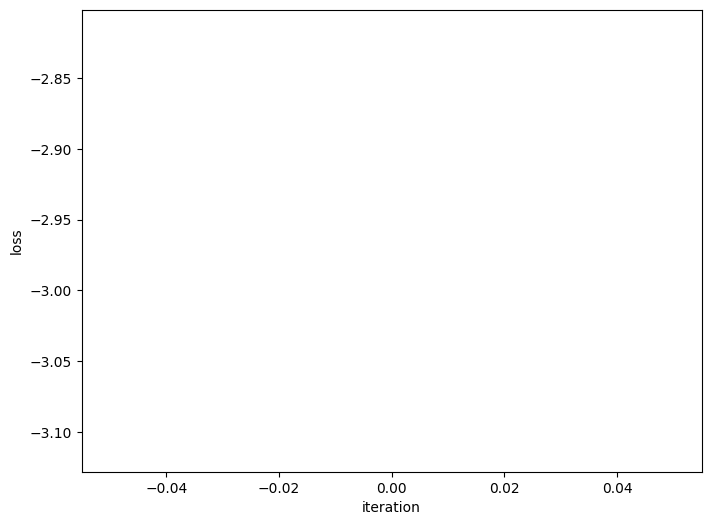

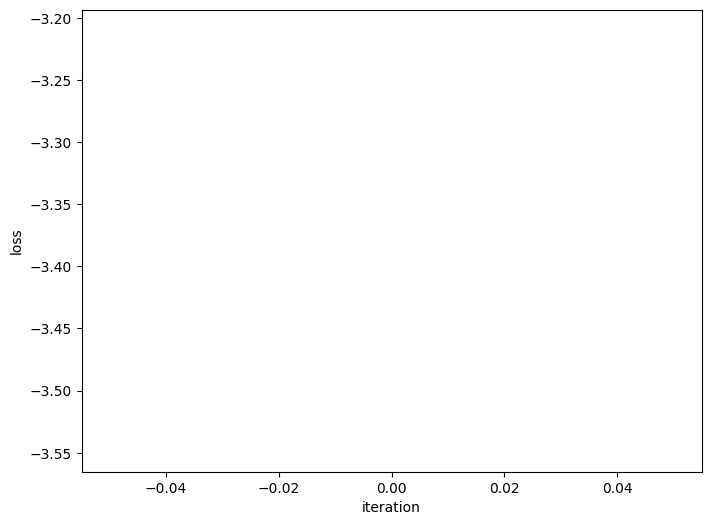

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -648.67626  validloss -617.10133±0.00000  bestvalidloss -617.10133  last_update 0
train: iter 1  trainloss -657.98384  validloss -617.51762±0.00000  bestvalidloss -617.51762  last_update 0
train: iter 2  trainloss -632.74888  validloss -551.41658±0.00000  bestvalidloss -617.51762  last_update 1
train: iter 3  trainloss -672.73108  validloss -597.54868±0.00000  bestvalidloss -617.51762  last_update 2
train: iter 4  trainloss -667.86240  validloss -608.69507±0.00000  bestvalidloss -617.51762  last_update 3
train: iter 5  trainloss -653.84308  validloss -594.45795±0.00000  bestvalidloss -617.51762  last_update 4
train: iter 6  trainloss -670.45990  validloss -604.26784±0.00000  bestvalidloss -617.51762  last_update 5
train: iter 7  trainloss -665.99069  validloss -608.12681±0.00000  bestvalidloss -617.51762  last_update 6
train: iter 8  trainloss -558.56284  validloss -533.32496±0.00000  bestvalidloss -617.51762  last_u

train: iter 76  trainloss -691.38874  validloss -614.50886±0.00000  bestvalidloss -634.32042  last_update 49
train: iter 77  trainloss -678.24117  validloss -594.24918±0.00000  bestvalidloss -634.32042  last_update 50
train: iter 78  trainloss -699.41846  validloss -604.72794±0.00000  bestvalidloss -634.32042  last_update 51
train: iter 79  trainloss -688.44150  validloss -597.22587±0.00000  bestvalidloss -634.32042  last_update 52
train: iter 80  trainloss -687.33108  validloss -610.52828±0.00000  bestvalidloss -634.32042  last_update 53
train: iter 81  trainloss -690.11664  validloss -597.17534±0.00000  bestvalidloss -634.32042  last_update 54
train: iter 82  trainloss -692.62695  validloss -589.78634±0.00000  bestvalidloss -634.32042  last_update 55
train: iter 83  trainloss -616.46035  validloss -561.62008±0.00000  bestvalidloss -634.32042  last_update 56
train: iter 84  trainloss -664.40341  validloss -568.92549±0.00000  bestvalidloss -634.32042  last_update 57
train: iter 85  tra

train: iter 151  trainloss -705.48316  validloss -609.65947±0.00000  bestvalidloss -635.11673  last_update 24
train: iter 152  trainloss -695.91518  validloss -557.67370±0.00000  bestvalidloss -635.11673  last_update 25
train: iter 153  trainloss -691.33822  validloss -596.68535±0.00000  bestvalidloss -635.11673  last_update 26
train: iter 154  trainloss -693.61486  validloss -620.01066±0.00000  bestvalidloss -635.11673  last_update 27
train: iter 155  trainloss -709.97425  validloss -591.66184±0.00000  bestvalidloss -635.11673  last_update 28
train: iter 156  trainloss -702.64233  validloss -586.56244±0.00000  bestvalidloss -635.11673  last_update 29
train: iter 157  trainloss -687.02826  validloss -511.84730±0.00000  bestvalidloss -635.11673  last_update 30
train: iter 158  trainloss -702.07612  validloss -599.15908±0.00000  bestvalidloss -635.11673  last_update 31
train: iter 159  trainloss -701.30022  validloss -619.31160±0.00000  bestvalidloss -635.11673  last_update 32
train: ite

train: iter 226  trainloss -703.63321  validloss -579.29954±0.00000  bestvalidloss -648.97555  last_update 21
train: iter 227  trainloss -712.02067  validloss -593.81328±0.00000  bestvalidloss -648.97555  last_update 22
train: iter 228  trainloss -720.86458  validloss -612.10666±0.00000  bestvalidloss -648.97555  last_update 23
train: iter 229  trainloss -700.93431  validloss -551.02718±0.00000  bestvalidloss -648.97555  last_update 24
train: iter 230  trainloss -707.61909  validloss -580.46398±0.00000  bestvalidloss -648.97555  last_update 25
train: iter 231  trainloss -720.63946  validloss -596.62983±0.00000  bestvalidloss -648.97555  last_update 26
train: iter 232  trainloss -704.78378  validloss -595.13266±0.00000  bestvalidloss -648.97555  last_update 27
train: iter 233  trainloss -706.43834  validloss -589.60561±0.00000  bestvalidloss -648.97555  last_update 28
train: iter 234  trainloss -699.63303  validloss -578.39236±0.00000  bestvalidloss -648.97555  last_update 29
train: ite

train: iter 301  trainloss -713.81993  validloss -582.97998±0.00000  bestvalidloss -648.97555  last_update 96
train: iter 302  trainloss -630.39976  validloss -545.40525±0.00000  bestvalidloss -648.97555  last_update 97
train: iter 303  trainloss -673.25782  validloss -519.45461±0.00000  bestvalidloss -648.97555  last_update 98
train: iter 304  trainloss -682.21642  validloss -558.31876±0.00000  bestvalidloss -648.97555  last_update 99
train: iter 305  trainloss -685.34392  validloss -544.78805±0.00000  bestvalidloss -648.97555  last_update 100
train: fin
penalty_target_min tensor(-11.6601) penalty_target_max tensor(29.3959)


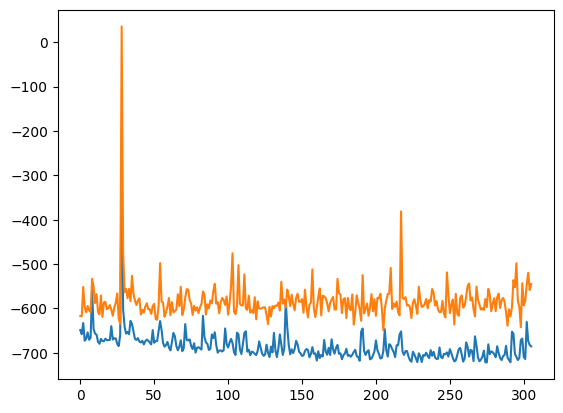

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-28 15:54:52.427610


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7
predict diverge [-29.23302441  33.92469098 187.56636825  10.62694321] [ 2.71184103e-01  2.46903053e+01  2.76711297e+02 -5.54104818e-01] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 196

 8

 9

 10
predict diverge [-32.85563963  -9.78812219 774.53450529 -17.45302527] [ 2.87293616e-01 -2.54938526e+01  8.53872856e+02 -2.79386607e-01] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 161

 11

 12

 13

 14

 15

 16

 17
predict diverge [-41.14198546 -25.27161489 -17.12063143  23.75620123] [ -0.48646939 -14.80022008   0.51253001  -1.24659597] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 148

 18

 19

 20

 21

 22

 23

 24

 25
predict diverge [ -41.9844592     3.73135707 -194.97904202   -7.21285911] [ 1.31570282e-01 -1.37290549e+00 -1.34452764e+02  6.88500589e-01] [107.82092   22.51174  164.27

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.37602  validloss 3.00209±0.00000  bestvalidloss 3.00209  last_update 0
train: iter 1  trainloss 0.58521  validloss 0.77102±0.00000  bestvalidloss 0.77102  last_update 0
train: iter 2  trainloss 0.52109  validloss 0.67409±0.00000  bestvalidloss 0.67409  last_update 0
train: iter 3  trainloss 0.48100  validloss 0.61819±0.00000  bestvalidloss 0.61819  last_update 0
train: iter 4  trainloss 0.46103  validloss 0.58842±0.00000  bestvalidloss 0.58842  last_update 0
train: iter 5  trainloss 0.43628  validloss 0.58078±0.00000  bestvalidloss 0.58078  last_update 0
train: iter 6  trainloss 0.42696  validloss 0.56879±0.00000  bestvalidloss 0.56879  last_update 0
train: iter 7  trainloss 0.41741  validloss 0.57054±0.00000  bestvalidloss 0.56879  last_update 1
train: iter 8  trainloss 0.40935  validloss 0.55668±0.00000  bestvalidloss 0.55668  last_update 0
train: iter 9  trainloss 0.40383  validloss 0.58648±0.00000  bestvalidloss 0.55668  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.32220  validloss 0.51062±0.00000  bestvalidloss 0.44815  last_update 9
train: iter 84  trainloss 0.32591  validloss 0.44941±0.00000  bestvalidloss 0.44815  last_update 10
train: iter 85  trainloss 0.32208  validloss 0.47591±0.00000  bestvalidloss 0.44815  last_update 11
train: iter 86  trainloss 0.32800  validloss 0.45410±0.00000  bestvalidloss 0.44815  last_update 12
train: iter 87  trainloss 0.32333  validloss 0.47710±0.00000  bestvalidloss 0.44815  last_update 13
train: iter 88  trainloss 0.32349  validloss 0.48468±0.00000  bestvalidloss 0.44815  last_update 14
train: iter 89  trainloss 0.31951  validloss 0.50980±0.00000  bestvalidloss 0.44815  last_update 15
train: iter 90  trainloss 0.31916  validloss 0.46322±0.00000  bestvalidloss 0.44815  last_update 16
train: iter 91  trainloss 0.32190  validloss 0.48457±0.00000  bestvalidloss 0.44815  last_update 17
train: iter 92  trainloss 0.32101  validloss 0.48124±0.00000  bestvalidloss 0.44815  last_update 18
t

train: iter 165  trainloss 0.30277  validloss 0.46543±0.00000  bestvalidloss 0.41781  last_update 2
train: iter 166  trainloss 0.30462  validloss 0.42464±0.00000  bestvalidloss 0.41781  last_update 3
train: iter 167  trainloss 0.30215  validloss 0.50795±0.00000  bestvalidloss 0.41781  last_update 4
train: iter 168  trainloss 0.30604  validloss 0.42207±0.00000  bestvalidloss 0.41781  last_update 5
train: iter 169  trainloss 0.30385  validloss 0.44080±0.00000  bestvalidloss 0.41781  last_update 6
train: iter 170  trainloss 0.30108  validloss 0.44516±0.00000  bestvalidloss 0.41781  last_update 7
train: iter 171  trainloss 0.30666  validloss 0.42825±0.00000  bestvalidloss 0.41781  last_update 8
train: iter 172  trainloss 0.30049  validloss 0.43452±0.00000  bestvalidloss 0.41781  last_update 9
train: iter 173  trainloss 0.31083  validloss 0.43324±0.00000  bestvalidloss 0.41781  last_update 10
train: iter 174  trainloss 0.30789  validloss 0.42111±0.00000  bestvalidloss 0.41781  last_update 1

train: iter 247  trainloss 0.29724  validloss 0.40961±0.00000  bestvalidloss 0.39054  last_update 10
train: iter 248  trainloss 0.28906  validloss 0.42758±0.00000  bestvalidloss 0.39054  last_update 11
train: iter 249  trainloss 0.29189  validloss 0.43454±0.00000  bestvalidloss 0.39054  last_update 12
train: iter 250  trainloss 0.28965  validloss 0.41523±0.00000  bestvalidloss 0.39054  last_update 13
train: iter 251  trainloss 0.29109  validloss 0.44379±0.00000  bestvalidloss 0.39054  last_update 14
train: iter 252  trainloss 0.29214  validloss 0.42470±0.00000  bestvalidloss 0.39054  last_update 15
train: iter 253  trainloss 0.28820  validloss 0.44827±0.00000  bestvalidloss 0.39054  last_update 16
train: iter 254  trainloss 0.29072  validloss 0.40435±0.00000  bestvalidloss 0.39054  last_update 17
train: iter 255  trainloss 0.29334  validloss 0.40182±0.00000  bestvalidloss 0.39054  last_update 18
train: iter 256  trainloss 0.28993  validloss 0.40796±0.00000  bestvalidloss 0.39054  last_

train: iter 329  trainloss 0.28491  validloss 0.38879±0.00000  bestvalidloss 0.37024  last_update 29
train: iter 330  trainloss 0.28328  validloss 0.38622±0.00000  bestvalidloss 0.37024  last_update 30
train: iter 331  trainloss 0.28097  validloss 0.39746±0.00000  bestvalidloss 0.37024  last_update 31
train: iter 332  trainloss 0.28452  validloss 0.38792±0.00000  bestvalidloss 0.37024  last_update 32
train: iter 333  trainloss 0.28339  validloss 0.38645±0.00000  bestvalidloss 0.37024  last_update 33
train: iter 334  trainloss 0.28931  validloss 0.40051±0.00000  bestvalidloss 0.37024  last_update 34
train: iter 335  trainloss 0.28168  validloss 0.38532±0.00000  bestvalidloss 0.37024  last_update 35
train: iter 336  trainloss 0.28118  validloss 0.38238±0.00000  bestvalidloss 0.37024  last_update 36
train: iter 337  trainloss 0.28280  validloss 0.42455±0.00000  bestvalidloss 0.37024  last_update 37
train: iter 338  trainloss 0.28441  validloss 0.37683±0.00000  bestvalidloss 0.37024  last_

train: iter 411  trainloss 0.27853  validloss 0.37709±0.00000  bestvalidloss 0.36256  last_update 8
train: iter 412  trainloss 0.27844  validloss 0.38752±0.00000  bestvalidloss 0.36256  last_update 9
train: iter 413  trainloss 0.27634  validloss 0.36385±0.00000  bestvalidloss 0.36256  last_update 10
train: iter 414  trainloss 0.28225  validloss 0.39468±0.00000  bestvalidloss 0.36256  last_update 11
train: iter 415  trainloss 0.27701  validloss 0.37943±0.00000  bestvalidloss 0.36256  last_update 12
train: iter 416  trainloss 0.27739  validloss 0.40038±0.00000  bestvalidloss 0.36256  last_update 13
train: iter 417  trainloss 0.27632  validloss 0.38418±0.00000  bestvalidloss 0.36256  last_update 14
train: iter 418  trainloss 0.27618  validloss 0.38331±0.00000  bestvalidloss 0.36256  last_update 15
train: iter 419  trainloss 0.27675  validloss 0.38029±0.00000  bestvalidloss 0.36256  last_update 16
train: iter 420  trainloss 0.27514  validloss 0.37788±0.00000  bestvalidloss 0.36256  last_up

train: iter 493  trainloss 0.27312  validloss 0.36795±0.00000  bestvalidloss 0.35945  last_update 34
train: iter 494  trainloss 0.27388  validloss 0.36864±0.00000  bestvalidloss 0.35945  last_update 35
train: iter 495  trainloss 0.27858  validloss 0.38571±0.00000  bestvalidloss 0.35945  last_update 36
train: iter 496  trainloss 0.27354  validloss 0.38319±0.00000  bestvalidloss 0.35945  last_update 37
train: iter 497  trainloss 0.27655  validloss 0.38804±0.00000  bestvalidloss 0.35945  last_update 38
train: iter 498  trainloss 0.27200  validloss 0.38432±0.00000  bestvalidloss 0.35945  last_update 39
train: iter 499  trainloss 0.27328  validloss 0.38371±0.00000  bestvalidloss 0.35945  last_update 40
train: iter 500  trainloss 0.27058  validloss 0.38664±0.00000  bestvalidloss 0.35945  last_update 41
train: iter 501  trainloss 0.27209  validloss 0.36474±0.00000  bestvalidloss 0.35945  last_update 42
train: iter 502  trainloss 0.27231  validloss 0.37702±0.00000  bestvalidloss 0.35945  last_

train: iter 575  trainloss 0.26920  validloss 0.38994±0.00000  bestvalidloss 0.35001  last_update 13
train: iter 576  trainloss 0.26780  validloss 0.37047±0.00000  bestvalidloss 0.35001  last_update 14
train: iter 577  trainloss 0.26750  validloss 0.35177±0.00000  bestvalidloss 0.35001  last_update 15
train: iter 578  trainloss 0.27166  validloss 0.38322±0.00000  bestvalidloss 0.35001  last_update 16
train: iter 579  trainloss 0.27022  validloss 0.37267±0.00000  bestvalidloss 0.35001  last_update 17
train: iter 580  trainloss 0.26691  validloss 0.35437±0.00000  bestvalidloss 0.35001  last_update 18
train: iter 581  trainloss 0.26960  validloss 0.36256±0.00000  bestvalidloss 0.35001  last_update 19
train: iter 582  trainloss 0.26942  validloss 0.37537±0.00000  bestvalidloss 0.35001  last_update 20
train: iter 583  trainloss 0.26972  validloss 0.38230±0.00000  bestvalidloss 0.35001  last_update 21
train: iter 584  trainloss 0.26759  validloss 0.37664±0.00000  bestvalidloss 0.35001  last_

train: iter 657  trainloss 0.26542  validloss 0.38414±0.00000  bestvalidloss 0.34962  last_update 64
train: iter 658  trainloss 0.26399  validloss 0.37301±0.00000  bestvalidloss 0.34962  last_update 65
train: iter 659  trainloss 0.26389  validloss 0.38219±0.00000  bestvalidloss 0.34962  last_update 66
train: iter 660  trainloss 0.26256  validloss 0.39456±0.00000  bestvalidloss 0.34962  last_update 67
train: iter 661  trainloss 0.26282  validloss 0.35955±0.00000  bestvalidloss 0.34962  last_update 68
train: iter 662  trainloss 0.26229  validloss 0.36197±0.00000  bestvalidloss 0.34962  last_update 69
train: iter 663  trainloss 0.26238  validloss 0.36291±0.00000  bestvalidloss 0.34962  last_update 70
train: iter 664  trainloss 0.26759  validloss 0.37363±0.00000  bestvalidloss 0.34962  last_update 71
train: iter 665  trainloss 0.26548  validloss 0.38150±0.00000  bestvalidloss 0.34962  last_update 72
train: iter 666  trainloss 0.26149  validloss 0.36881±0.00000  bestvalidloss 0.34962  last_

train_loss:  -4.281535176813604
valid_loss:  -4.440969561195373
weight_alpha 1.0 h_min_tilde -11.660116 ell_tilde -4.313422053689958 kappa_tilde 0.00036893853607345773
train_loss:  -3.7197681945800776
valid_loss:  -3.002983618164062
weight_alpha 0.1 h_min_tilde -11.660116 ell_tilde -3.5764112792968747 kappa_tilde 0.0003517181450770322


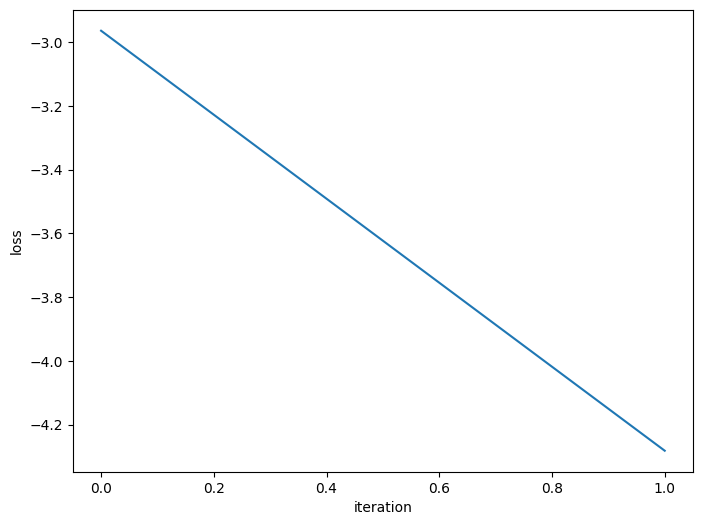

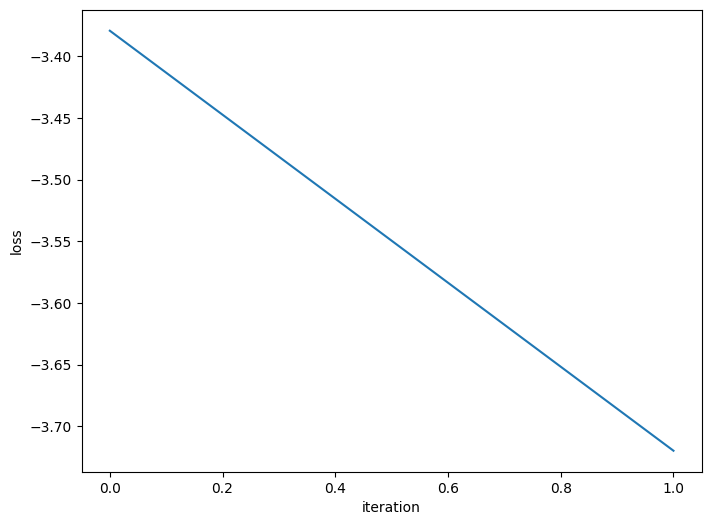

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -746.59163  validloss -598.74162±0.00000  bestvalidloss -598.74162  last_update 0
train: iter 1  trainloss -762.19390  validloss -644.06012±0.00000  bestvalidloss -644.06012  last_update 0
train: iter 2  trainloss -763.85632  validloss -572.69423±0.00000  bestvalidloss -644.06012  last_update 1
train: iter 3  trainloss -755.43555  validloss -642.17280±0.00000  bestvalidloss -644.06012  last_update 2
train: iter 4  trainloss -775.54395  validloss -648.01111±0.00000  bestvalidloss -648.01111  last_update 0
train: iter 5  trainloss -755.72009  validloss -577.22561±0.00000  bestvalidloss -648.01111  last_update 1
train: iter 6  trainloss -787.43767  validloss -633.50148±0.00000  bestvalidloss -648.01111  last_update 2
train: iter 7  trainloss -760.85858  validloss -658.84025±0.00000  bestvalidloss -658.84025  last_update 0
train: iter 8  trainloss -756.00972  validloss -545.58307±0.00000  bestvalidloss -658.84025  last_u

train: iter 76  trainloss -777.24729  validloss -655.21881±0.00000  bestvalidloss -669.40092  last_update 8
train: iter 77  trainloss -778.87216  validloss -651.51736±0.00000  bestvalidloss -669.40092  last_update 9
train: iter 78  trainloss -782.49662  validloss -600.99692±0.00000  bestvalidloss -669.40092  last_update 10
train: iter 79  trainloss -716.52071  validloss -641.05073±0.00000  bestvalidloss -669.40092  last_update 11
train: iter 80  trainloss -724.42054  validloss -556.60482±0.00000  bestvalidloss -669.40092  last_update 12
train: iter 81  trainloss -774.27406  validloss -633.67900±0.00000  bestvalidloss -669.40092  last_update 13
train: iter 82  trainloss -792.28406  validloss -628.97140±0.00000  bestvalidloss -669.40092  last_update 14
train: iter 83  trainloss -778.56720  validloss -646.45592±0.00000  bestvalidloss -669.40092  last_update 15
train: iter 84  trainloss -771.34691  validloss -639.02758±0.00000  bestvalidloss -669.40092  last_update 16
train: iter 85  train

train: iter 151  trainloss -795.59250  validloss -628.21895±0.00000  bestvalidloss -669.98971  last_update 57
train: iter 152  trainloss -779.69117  validloss -649.14917±0.00000  bestvalidloss -669.98971  last_update 58
train: iter 153  trainloss -724.32315  validloss -625.59526±0.00000  bestvalidloss -669.98971  last_update 59
train: iter 154  trainloss -689.57294  validloss -559.95785±0.00000  bestvalidloss -669.98971  last_update 60
train: iter 155  trainloss -726.52327  validloss -550.63480±0.00000  bestvalidloss -669.98971  last_update 61
train: iter 156  trainloss -768.80452  validloss -579.17612±0.00000  bestvalidloss -669.98971  last_update 62
train: iter 157  trainloss -744.90096  validloss -589.37264±0.00000  bestvalidloss -669.98971  last_update 63
train: iter 158  trainloss -777.76015  validloss -635.91815±0.00000  bestvalidloss -669.98971  last_update 64
train: iter 159  trainloss -785.65786  validloss -607.57314±0.00000  bestvalidloss -669.98971  last_update 65
train: ite

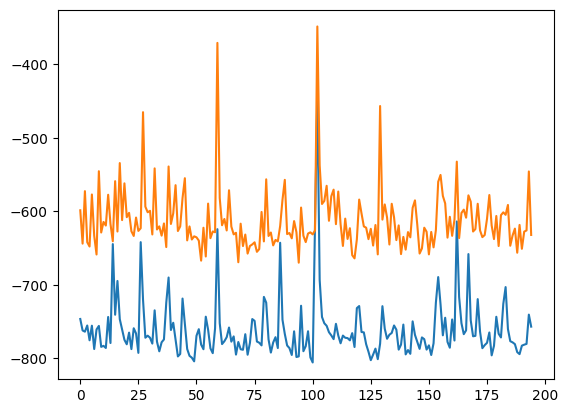

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-07-28 16:26:20.902473


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3
predict diverge [-32.67424256  -0.65085066 -24.32562935 -31.76148693] [-0.01470795  0.14090971 -1.52352987 -4.62245131] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 172

 4
predict diverge [-18.48769408  22.70724206 -48.82950695 -28.36228897] [ 0.80449589  1.23536378 -1.55138562 -0.99872491] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 119

 5

 6

 7

 8
predict diverge [-31.52399649   8.27016565 -25.12502526 -30.16836706] [ 0.28084665  1.53403949 -1.57189774 -3.47832428] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 182

 9

 10

 11

 12

 13

 14
predict diverge [-11.99341841  22.89137903 -45.1374201  -20.95395534] [ 0.87373872  0.93489786 -1.08443021 -0.71934861] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 157

 15

 16
predict diverge [-23.2214

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58267  validloss 0.90730±0.00000  bestvalidloss 0.90730  last_update 0
train: iter 1  trainloss 0.49221  validloss 0.45622±0.00000  bestvalidloss 0.45622  last_update 0
train: iter 2  trainloss 0.47664  validloss 0.43283±0.00000  bestvalidloss 0.43283  last_update 0
train: iter 3  trainloss 0.46742  validloss 0.43790±0.00000  bestvalidloss 0.43283  last_update 1
train: iter 4  trainloss 0.45646  validloss 0.46239±0.00000  bestvalidloss 0.43283  last_update 2
train: iter 5  trainloss 0.44785  validloss 0.41966±0.00000  bestvalidloss 0.41966  last_update 0
train: iter 6  trainloss 0.44358  validloss 0.42443±0.00000  bestvalidloss 0.41966  last_update 1
train: iter 7  trainloss 0.44192  validloss 0.42444±0.00000  bestvalidloss 0.41966  last_update 2
train: iter 8  trainloss 0.43440  validloss 0.43005±0.00000  bestvalidloss 0.41966  last_update 3
train: iter 9  trainloss 0.43663  validloss 0.41052±0.00000  bestvalidloss 0.41052  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.37391  validloss 0.40164±0.00000  bestvalidloss 0.38492  last_update 10
train: iter 84  trainloss 0.37397  validloss 0.40131±0.00000  bestvalidloss 0.38492  last_update 11
train: iter 85  trainloss 0.37926  validloss 0.41650±0.00000  bestvalidloss 0.38492  last_update 12
train: iter 86  trainloss 0.37436  validloss 0.40542±0.00000  bestvalidloss 0.38492  last_update 13
train: iter 87  trainloss 0.37869  validloss 0.38831±0.00000  bestvalidloss 0.38492  last_update 14
train: iter 88  trainloss 0.37412  validloss 0.39542±0.00000  bestvalidloss 0.38492  last_update 15
train: iter 89  trainloss 0.37698  validloss 0.41373±0.00000  bestvalidloss 0.38492  last_update 16
train: iter 90  trainloss 0.37503  validloss 0.39763±0.00000  bestvalidloss 0.38492  last_update 17
train: iter 91  trainloss 0.37315  validloss 0.39342±0.00000  bestvalidloss 0.38492  last_update 18
train: iter 92  trainloss 0.37375  validloss 0.41164±0.00000  bestvalidloss 0.38492  last_update 19


train: iter 165  trainloss 0.36105  validloss 0.40502±0.00000  bestvalidloss 0.38492  last_update 92
train: iter 166  trainloss 0.36131  validloss 0.41379±0.00000  bestvalidloss 0.38492  last_update 93
train: iter 167  trainloss 0.35930  validloss 0.42731±0.00000  bestvalidloss 0.38492  last_update 94
train: iter 168  trainloss 0.36302  validloss 0.40198±0.00000  bestvalidloss 0.38492  last_update 95
train: iter 169  trainloss 0.36150  validloss 0.41457±0.00000  bestvalidloss 0.38492  last_update 96
train: iter 170  trainloss 0.35998  validloss 0.41113±0.00000  bestvalidloss 0.38492  last_update 97
train: iter 171  trainloss 0.36427  validloss 0.38986±0.00000  bestvalidloss 0.38492  last_update 98
train: iter 172  trainloss 0.36053  validloss 0.41653±0.00000  bestvalidloss 0.38492  last_update 99
train: iter 173  trainloss 0.36358  validloss 0.40553±0.00000  bestvalidloss 0.38492  last_update 100
train: fin


train_loss:  -4.688956922346354
valid_loss:  -4.067095984363556
weight_alpha 1.0 h_min_tilde -11.802895 ell_tilde -4.564584734749794 kappa_tilde 0.00037169046031267745
train_loss:  -4.120745715248584
valid_loss:  -3.2358638444900514
weight_alpha 0.1 h_min_tilde -11.802895 ell_tilde -3.943769341096878 kappa_tilde 0.0003567080372878027


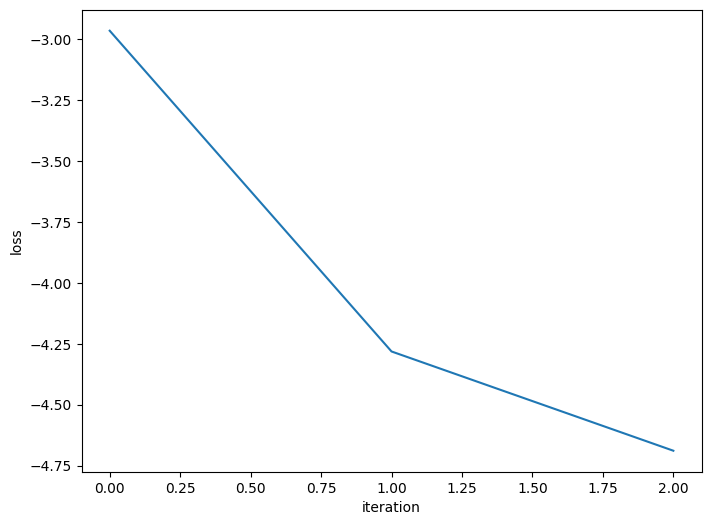

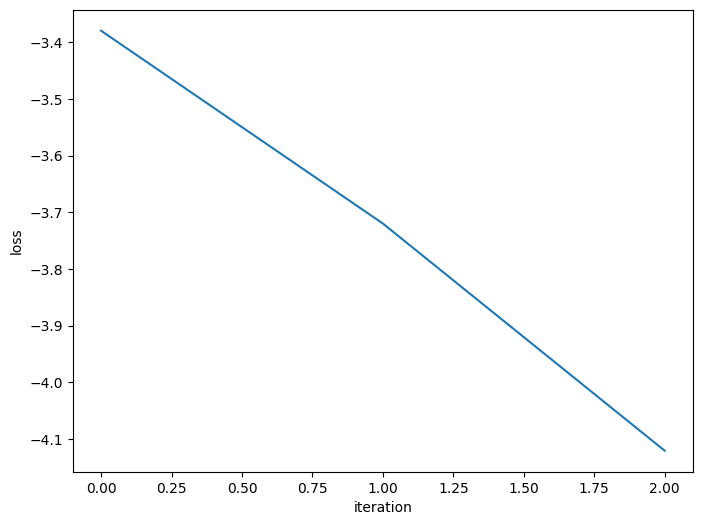

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -828.53368  validloss -645.11703±0.00000  bestvalidloss -645.11703  last_update 0
train: iter 1  trainloss -834.61961  validloss -644.46837±0.00000  bestvalidloss -645.11703  last_update 1
train: iter 2  trainloss -809.56054  validloss -593.90252±0.00000  bestvalidloss -645.11703  last_update 2
train: iter 3  trainloss -827.59606  validloss -635.05835±0.00000  bestvalidloss -645.11703  last_update 3
train: iter 4  trainloss -812.19973  validloss -582.28152±0.00000  bestvalidloss -645.11703  last_update 4
train: iter 5  trainloss -823.81618  validloss -652.87133±0.00000  bestvalidloss -652.87133  last_update 0
train: iter 6  trainloss -836.50374  validloss -666.37119±0.00000  bestvalidloss -666.37119  last_update 0
train: iter 7  trainloss -842.00836  validloss -661.79818±0.00000  bestvalidloss -666.37119  last_update 1
train: iter 8  trainloss -838.92484  validloss -695.79822±0.00000  bestvalidloss -695.79822  last_u

train: iter 76  trainloss -849.24656  validloss -669.00196±0.00000  bestvalidloss -713.46830  last_update 19
train: iter 77  trainloss -844.29553  validloss -667.31876±0.00000  bestvalidloss -713.46830  last_update 20
train: iter 78  trainloss -835.53818  validloss -662.60652±0.00000  bestvalidloss -713.46830  last_update 21
train: iter 79  trainloss -789.63714  validloss -687.73559±0.00000  bestvalidloss -713.46830  last_update 22
train: iter 80  trainloss -843.78378  validloss -675.19278±0.00000  bestvalidloss -713.46830  last_update 23
train: iter 81  trainloss -845.72190  validloss -697.79097±0.00000  bestvalidloss -713.46830  last_update 24
train: iter 82  trainloss -856.80734  validloss -706.59602±0.00000  bestvalidloss -713.46830  last_update 25
train: iter 83  trainloss -834.13203  validloss -696.96860±0.00000  bestvalidloss -713.46830  last_update 26
train: iter 84  trainloss -827.64547  validloss -625.24603±0.00000  bestvalidloss -713.46830  last_update 27
train: iter 85  tra

train: iter 151  trainloss -852.03487  validloss -677.57493±0.00000  bestvalidloss -722.86885  last_update 32
train: iter 152  trainloss -850.36507  validloss -687.20141±0.00000  bestvalidloss -722.86885  last_update 33
train: iter 153  trainloss -841.54178  validloss -687.70712±0.00000  bestvalidloss -722.86885  last_update 34
train: iter 154  trainloss -835.34154  validloss -673.83783±0.00000  bestvalidloss -722.86885  last_update 35
train: iter 155  trainloss -866.18794  validloss -700.70379±0.00000  bestvalidloss -722.86885  last_update 36
train: iter 156  trainloss -840.40126  validloss -715.93136±0.00000  bestvalidloss -722.86885  last_update 37
train: iter 157  trainloss -781.87156  validloss -642.19766±0.00000  bestvalidloss -722.86885  last_update 38
train: iter 158  trainloss -852.20398  validloss -679.61571±0.00000  bestvalidloss -722.86885  last_update 39
train: iter 159  trainloss -864.53575  validloss -681.28689±0.00000  bestvalidloss -722.86885  last_update 40
train: ite

train: iter 226  trainloss -828.27220  validloss -666.93958±0.00000  bestvalidloss -749.13745  last_update 7
train: iter 227  trainloss -837.29733  validloss -676.04687±0.00000  bestvalidloss -749.13745  last_update 8
train: iter 228  trainloss -799.68755  validloss -685.32102±0.00000  bestvalidloss -749.13745  last_update 9
train: iter 229  trainloss -803.16928  validloss -634.11354±0.00000  bestvalidloss -749.13745  last_update 10
train: iter 230  trainloss -849.07398  validloss -677.28417±0.00000  bestvalidloss -749.13745  last_update 11
train: iter 231  trainloss -847.35878  validloss -704.00783±0.00000  bestvalidloss -749.13745  last_update 12
train: iter 232  trainloss -856.16837  validloss -724.79319±0.00000  bestvalidloss -749.13745  last_update 13
train: iter 233  trainloss -829.28177  validloss -674.03179±0.00000  bestvalidloss -749.13745  last_update 14
train: iter 234  trainloss -851.22148  validloss -691.76614±0.00000  bestvalidloss -749.13745  last_update 15
train: iter 2

train: iter 301  trainloss -850.06918  validloss -719.13247±0.00000  bestvalidloss -749.13745  last_update 82
train: iter 302  trainloss -837.87894  validloss -648.45749±0.00000  bestvalidloss -749.13745  last_update 83
train: iter 303  trainloss -850.38304  validloss -689.67374±0.00000  bestvalidloss -749.13745  last_update 84
train: iter 304  trainloss -853.24133  validloss -663.60832±0.00000  bestvalidloss -749.13745  last_update 85
train: iter 305  trainloss -831.57232  validloss -627.71557±0.00000  bestvalidloss -749.13745  last_update 86
train: iter 306  trainloss -841.72456  validloss -720.12338±0.00000  bestvalidloss -749.13745  last_update 87
train: iter 307  trainloss -811.15517  validloss -694.17132±0.00000  bestvalidloss -749.13745  last_update 88
train: iter 308  trainloss -842.70043  validloss -656.54027±0.00000  bestvalidloss -749.13745  last_update 89
train: iter 309  trainloss -817.76449  validloss -690.86431±0.00000  bestvalidloss -749.13745  last_update 90
train: ite

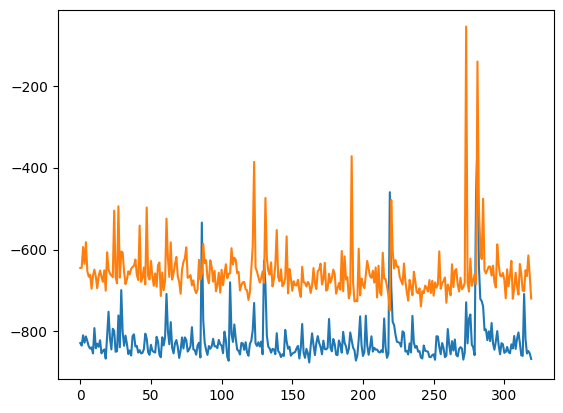

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-07-28 16:55:21.711094


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5
predict diverge [-43.416513   -23.05122638  38.36034127   8.35658697] [-1.08099962 -0.58585294  0.27846095  0.67132028] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 99

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75
predict diverge [-33.71431234 -22.59393028  39.4690406   10.11012804] [-1.11107664 -0.52588968  0.39947164 -0.14578286] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 95

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.62635  validloss 1.32909±0.00000  bestvalidloss 1.32909  last_update 0
train: iter 1  trainloss 0.55696  validloss 0.54940±0.00000  bestvalidloss 0.54940  last_update 0
train: iter 2  trainloss 0.54955  validloss 0.53791±0.00000  bestvalidloss 0.53791  last_update 0
train: iter 3  trainloss 0.53730  validloss 0.52700±0.00000  bestvalidloss 0.52700  last_update 0
train: iter 4  trainloss 0.53207  validloss 0.52186±0.00000  bestvalidloss 0.52186  last_update 0
train: iter 5  trainloss 0.52663  validloss 0.53195±0.00000  bestvalidloss 0.52186  last_update 1
train: iter 6  trainloss 0.52466  validloss 0.50564±0.00000  bestvalidloss 0.50564  last_update 0
train: iter 7  trainloss 0.52137  validloss 0.49617±0.00000  bestvalidloss 0.49617  last_update 0
train: iter 8  trainloss 0.51427  validloss 0.50312±0.00000  bestvalidloss 0.49617  last_update 1
train: iter 9  trainloss 0.51587  validloss 0.50777±0.00000  bestvalidloss 0.49617  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.46877  validloss 0.48929±0.00000  bestvalidloss 0.47282  last_update 18
train: iter 84  trainloss 0.45961  validloss 0.50320±0.00000  bestvalidloss 0.47282  last_update 19
train: iter 85  trainloss 0.45829  validloss 0.48398±0.00000  bestvalidloss 0.47282  last_update 20
train: iter 86  trainloss 0.46059  validloss 0.52764±0.00000  bestvalidloss 0.47282  last_update 21
train: iter 87  trainloss 0.45722  validloss 0.49537±0.00000  bestvalidloss 0.47282  last_update 22
train: iter 88  trainloss 0.45261  validloss 0.49468±0.00000  bestvalidloss 0.47282  last_update 23
train: iter 89  trainloss 0.46113  validloss 0.49461±0.00000  bestvalidloss 0.47282  last_update 24
train: iter 90  trainloss 0.45388  validloss 0.48422±0.00000  bestvalidloss 0.47282  last_update 25
train: iter 91  trainloss 0.45796  validloss 0.48983±0.00000  bestvalidloss 0.47282  last_update 26
train: iter 92  trainloss 0.45465  validloss 0.50132±0.00000  bestvalidloss 0.47282  last_update 27


train: iter 165  trainloss 0.44318  validloss 0.49671±0.00000  bestvalidloss 0.47282  last_update 100
train: fin


train_loss:  -5.861548232996464
valid_loss:  -6.373223795700072
weight_alpha 1.0 h_min_tilde -11.970985 ell_tilde -5.963883345537186 kappa_tilde 0.0004080068875222053
train_loss:  -5.002272126632929
valid_loss:  -4.093385832214357
weight_alpha 0.1 h_min_tilde -11.970985 ell_tilde -4.820494867749215 kappa_tilde 0.00037396596775634726


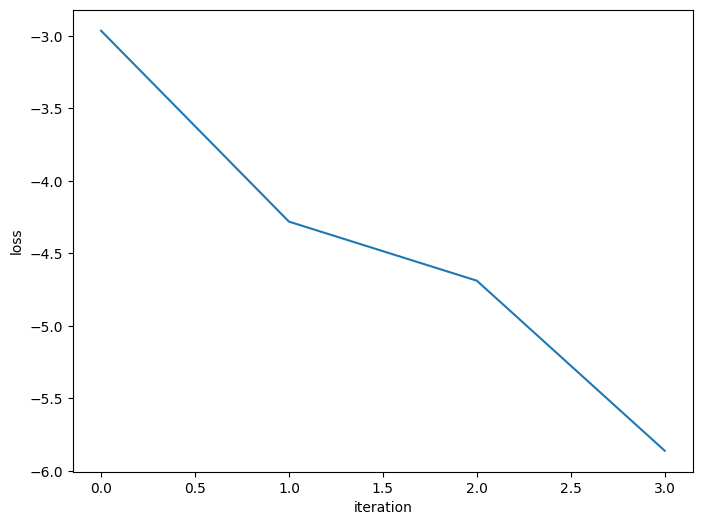

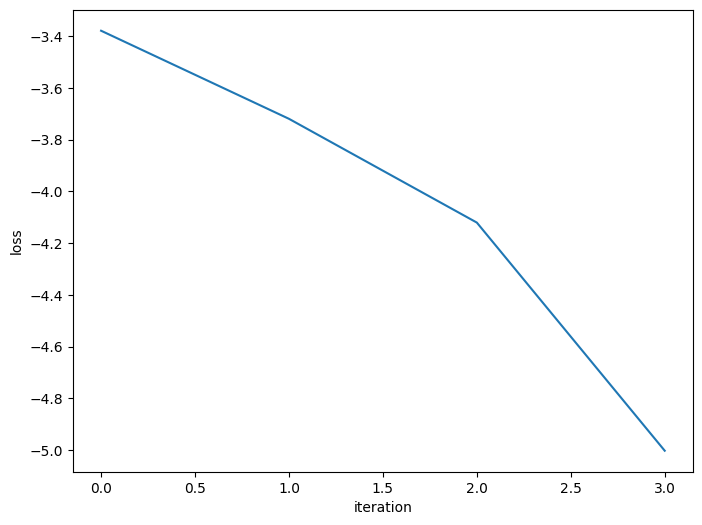

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -952.50517  validloss -819.89162±0.00000  bestvalidloss -819.89162  last_update 0
train: iter 1  trainloss -966.98355  validloss -792.63802±0.00000  bestvalidloss -819.89162  last_update 1
train: iter 2  trainloss -984.03948  validloss -811.46805±0.00000  bestvalidloss -819.89162  last_update 2
train: iter 3  trainloss -997.62963  validloss -807.61947±0.00000  bestvalidloss -819.89162  last_update 3
train: iter 4  trainloss -804.79429  validloss -486.09709±0.00000  bestvalidloss -819.89162  last_update 4
train: iter 5  trainloss -968.27840  validloss -798.19084±0.00000  bestvalidloss -819.89162  last_update 5
train: iter 6  trainloss -957.54773  validloss -809.40894±0.00000  bestvalidloss -819.89162  last_update 6
train: iter 7  trainloss -975.38668  validloss -828.54322±0.00000  bestvalidloss -828.54322  last_update 0
train: iter 8  trainloss -982.02953  validloss -794.80983±0.00000  bestvalidloss -828.54322  last_u

train: iter 76  trainloss -989.71399  validloss -860.72409±0.00000  bestvalidloss -869.85843  last_update 31
train: iter 77  trainloss -937.48865  validloss -765.39563±0.00000  bestvalidloss -869.85843  last_update 32
train: iter 78  trainloss -965.97319  validloss -804.53974±0.00000  bestvalidloss -869.85843  last_update 33
train: iter 79  trainloss -984.00397  validloss -828.17950±0.00000  bestvalidloss -869.85843  last_update 34
train: iter 80  trainloss -618.86766  validloss -739.35961±0.00000  bestvalidloss -869.85843  last_update 35
train: iter 81  trainloss -777.36398  validloss -516.81618±0.00000  bestvalidloss -869.85843  last_update 36
train: iter 82  trainloss -897.58443  validloss -756.05478±0.00000  bestvalidloss -869.85843  last_update 37
train: iter 83  trainloss -928.85062  validloss -738.39377±0.00000  bestvalidloss -869.85843  last_update 38
train: iter 84  trainloss -920.09853  validloss -747.89927±0.00000  bestvalidloss -869.85843  last_update 39
train: iter 85  tra

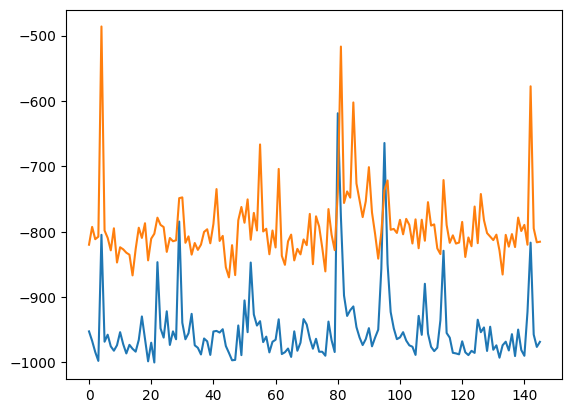

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-07-28 17:23:23.035946


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4
predict diverge [-24.59192355 -50.47626728  37.19205224  24.90436806] [ -0.64032717 -39.69622128   0.57637141  -4.11494534] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 78

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53
predict diverge [-27.02356139 -22.55660256  26.95642717   4.86960526] [-1.08177163 -0.05862006  0.15267449  0.28869224] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 51

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78
predict diverge [-13.91116893 -23.98237477  33.08689041   8.21672147] [ -0.5435683  -14.02081503   0.44104009 -16.68800546] [107.82092   22.51174  164.27458   29.9

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.54329  validloss 0.73327±0.00000  bestvalidloss 0.73327  last_update 0
train: iter 1  trainloss 0.51661  validloss 0.59340±0.00000  bestvalidloss 0.59340  last_update 0
train: iter 2  trainloss 0.51230  validloss 0.59967±0.00000  bestvalidloss 0.59340  last_update 1
train: iter 3  trainloss 0.52185  validloss 0.61682±0.00000  bestvalidloss 0.59340  last_update 2
train: iter 4  trainloss 0.52143  validloss 0.59495±0.00000  bestvalidloss 0.59340  last_update 3
train: iter 5  trainloss 0.50875  validloss 0.57474±0.00000  bestvalidloss 0.57474  last_update 0
train: iter 6  trainloss 0.50872  validloss 0.59666±0.00000  bestvalidloss 0.57474  last_update 1
train: iter 7  trainloss 0.50610  validloss 0.59066±0.00000  bestvalidloss 0.57474  last_update 2
train: iter 8  trainloss 0.50442  validloss 0.58879±0.00000  bestvalidloss 0.57474  last_update 3
train: iter 9  trainloss 0.50133  validloss 0.58408±0.00000  bestvalidloss 0.57474  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.48054  validloss 0.58038±0.00000  bestvalidloss 0.56629  last_update 44
train: iter 84  trainloss 0.47638  validloss 0.57590±0.00000  bestvalidloss 0.56629  last_update 45
train: iter 85  trainloss 0.47741  validloss 0.61767±0.00000  bestvalidloss 0.56629  last_update 46
train: iter 86  trainloss 0.47218  validloss 0.57101±0.00000  bestvalidloss 0.56629  last_update 47
train: iter 87  trainloss 0.47062  validloss 0.58023±0.00000  bestvalidloss 0.56629  last_update 48
train: iter 88  trainloss 0.47723  validloss 0.57156±0.00000  bestvalidloss 0.56629  last_update 49
train: iter 89  trainloss 0.47188  validloss 0.57955±0.00000  bestvalidloss 0.56629  last_update 50
train: iter 90  trainloss 0.47550  validloss 0.58113±0.00000  bestvalidloss 0.56629  last_update 51
train: iter 91  trainloss 0.46992  validloss 0.57624±0.00000  bestvalidloss 0.56629  last_update 52
train: iter 92  trainloss 0.47106  validloss 0.57072±0.00000  bestvalidloss 0.56629  last_update 53


train: iter 165  trainloss 0.45945  validloss 0.58486±0.00000  bestvalidloss 0.56343  last_update 39
train: iter 166  trainloss 0.46160  validloss 0.57282±0.00000  bestvalidloss 0.56343  last_update 40
train: iter 167  trainloss 0.46106  validloss 0.58078±0.00000  bestvalidloss 0.56343  last_update 41
train: iter 168  trainloss 0.46430  validloss 0.58522±0.00000  bestvalidloss 0.56343  last_update 42
train: iter 169  trainloss 0.46025  validloss 0.58132±0.00000  bestvalidloss 0.56343  last_update 43
train: iter 170  trainloss 0.46016  validloss 0.59767±0.00000  bestvalidloss 0.56343  last_update 44
train: iter 171  trainloss 0.46421  validloss 0.61049±0.00000  bestvalidloss 0.56343  last_update 45
train: iter 172  trainloss 0.45861  validloss 0.57966±0.00000  bestvalidloss 0.56343  last_update 46
train: iter 173  trainloss 0.46306  validloss 0.59031±0.00000  bestvalidloss 0.56343  last_update 47
train: iter 174  trainloss 0.45979  validloss 0.56631±0.00000  bestvalidloss 0.56343  last_

train_loss:  -7.8888021952152245
valid_loss:  -8.508551851153374
weight_alpha 1.0 h_min_tilde -11.958752 ell_tilde -8.012752126402853 kappa_tilde 0.0005034095894782269
train_loss:  -4.999917185473442
valid_loss:  -4.221387732315064
weight_alpha 0.1 h_min_tilde -11.958752 ell_tilde -4.844211294841767 kappa_tilde 0.0003749096124188023


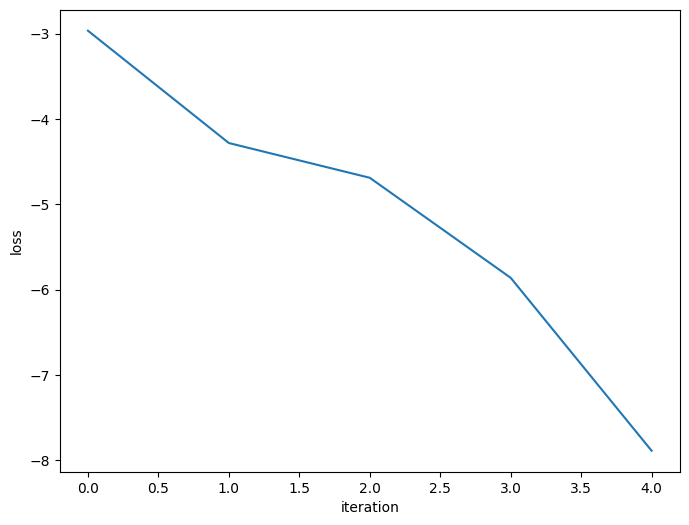

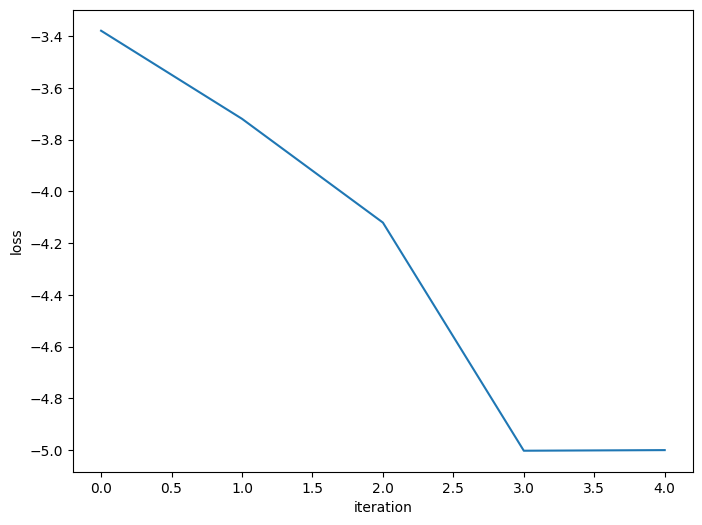

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -998.37135  validloss -840.59624±0.00000  bestvalidloss -840.59624  last_update 0
train: iter 1  trainloss -1005.40613  validloss -828.91721±0.00000  bestvalidloss -840.59624  last_update 1
train: iter 2  trainloss -1006.97917  validloss -843.43808±0.00000  bestvalidloss -843.43808  last_update 0
train: iter 3  trainloss -984.48579  validloss -840.00394±0.00000  bestvalidloss -843.43808  last_update 1
train: iter 4  trainloss -1001.53023  validloss -837.93818±0.00000  bestvalidloss -843.43808  last_update 2
train: iter 5  trainloss -998.40687  validloss -844.30905±0.00000  bestvalidloss -844.30905  last_update 0
train: iter 6  trainloss -997.09928  validloss -821.58041±0.00000  bestvalidloss -844.30905  last_update 1
train: iter 7  trainloss -1023.44355  validloss -861.64271±0.00000  bestvalidloss -861.64271  last_update 0
train: iter 8  trainloss -998.55588  validloss -873.09770±0.00000  bestvalidloss -873.09770  la

train: iter 75  trainloss -980.61527  validloss -805.82318±0.00000  bestvalidloss -897.55221  last_update 12
train: iter 76  trainloss -950.05418  validloss -874.38333±0.00000  bestvalidloss -897.55221  last_update 13
train: iter 77  trainloss -994.04106  validloss -817.30462±0.00000  bestvalidloss -897.55221  last_update 14
train: iter 78  trainloss -997.16704  validloss -858.61202±0.00000  bestvalidloss -897.55221  last_update 15
train: iter 79  trainloss -997.43552  validloss -798.37727±0.00000  bestvalidloss -897.55221  last_update 16
train: iter 80  trainloss -981.19896  validloss -818.71302±0.00000  bestvalidloss -897.55221  last_update 17
train: iter 81  trainloss -1020.71718  validloss -853.54391±0.00000  bestvalidloss -897.55221  last_update 18
train: iter 82  trainloss -1024.61189  validloss -832.10975±0.00000  bestvalidloss -897.55221  last_update 19
train: iter 83  trainloss -1002.33565  validloss -836.26000±0.00000  bestvalidloss -897.55221  last_update 20
train: iter 84  

train: iter 150  trainloss -1001.86860  validloss -819.93542±0.00000  bestvalidloss -897.55221  last_update 87
train: iter 151  trainloss -1014.37090  validloss -814.49191±0.00000  bestvalidloss -897.55221  last_update 88
train: iter 152  trainloss -1006.36930  validloss -838.85646±0.00000  bestvalidloss -897.55221  last_update 89
train: iter 153  trainloss -973.16928  validloss -777.18954±0.00000  bestvalidloss -897.55221  last_update 90
train: iter 154  trainloss -1000.04537  validloss -794.30131±0.00000  bestvalidloss -897.55221  last_update 91
train: iter 155  trainloss -1015.39640  validloss -840.38589±0.00000  bestvalidloss -897.55221  last_update 92
train: iter 156  trainloss -1028.85365  validloss -843.26592±0.00000  bestvalidloss -897.55221  last_update 93
train: iter 157  trainloss -964.62811  validloss -818.77578±0.00000  bestvalidloss -897.55221  last_update 94
train: iter 158  trainloss -994.66926  validloss -808.80985±0.00000  bestvalidloss -897.55221  last_update 95
trai

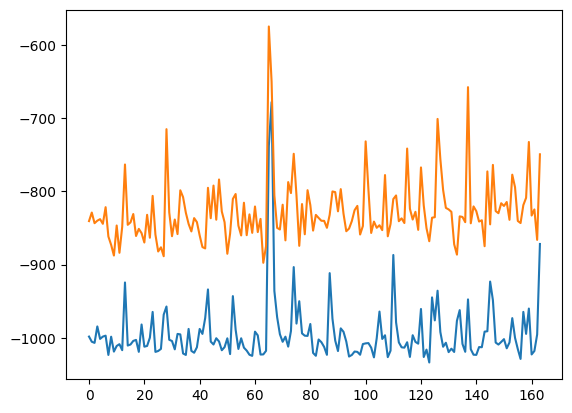

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-07-28 17:51:32.960934


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4
predict diverge [-11.70941631 -30.71759994  28.11249106  21.85043426] [ -0.85657242 -13.32608045   1.31557272   1.56771302] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 51

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26
predict diverge [-12.20720594   6.99332405  34.16664266  31.11873148] [ 0.35394301 -1.69603071  1.07198326  7.13918886] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 72

 27

 28

 29
predict diverge [-11.58121976 -24.35187925  28.46748658  26.90373343] [-0.87590302 -6.06652106  0.92368887  5.12342873] [107.82092   22.51174  164.27458   29.974638] [53.91046  11.25587  82.13729  14.987319] sim_timestep 41

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47
predict diverge [-16.61596971 -22.99909773  39.43514096  36.7854567 ] [-0.67938642 -9.26811328

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.58965  validloss 0.66000±0.00000  bestvalidloss 0.66000  last_update 0
train: iter 1  trainloss 0.56302  validloss 0.60019±0.00000  bestvalidloss 0.60019  last_update 0
train: iter 2  trainloss 0.56351  validloss 0.59776±0.00000  bestvalidloss 0.59776  last_update 0
train: iter 3  trainloss 0.55191  validloss 0.58554±0.00000  bestvalidloss 0.58554  last_update 0
train: iter 4  trainloss 0.54870  validloss 0.59303±0.00000  bestvalidloss 0.58554  last_update 1
train: iter 5  trainloss 0.54160  validloss 0.59341±0.00000  bestvalidloss 0.58554  last_update 2
train: iter 6  trainloss 0.54733  validloss 0.63052±0.00000  bestvalidloss 0.58554  last_update 3
train: iter 7  trainloss 0.54418  validloss 0.59364±0.00000  bestvalidloss 0.58554  last_update 4
train: iter 8  trainloss 0.53575  validloss 0.62258±0.00000  bestvalidloss 0.58554  last_update 5
train: iter 9  trainloss 0.52971  validloss 0.59004±0.00000  bestvalidloss 0.58554  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.49287  validloss 0.59049±0.00000  bestvalidloss 0.58239  last_update 49
train: iter 84  trainloss 0.48943  validloss 0.59406±0.00000  bestvalidloss 0.58239  last_update 50
train: iter 85  trainloss 0.49037  validloss 0.60112±0.00000  bestvalidloss 0.58239  last_update 51
train: iter 86  trainloss 0.49082  validloss 0.58373±0.00000  bestvalidloss 0.58239  last_update 52
train: iter 87  trainloss 0.48823  validloss 0.58331±0.00000  bestvalidloss 0.58239  last_update 53
train: iter 88  trainloss 0.49148  validloss 0.59992±0.00000  bestvalidloss 0.58239  last_update 54
train: iter 89  trainloss 0.48947  validloss 0.60619±0.00000  bestvalidloss 0.58239  last_update 55
train: iter 90  trainloss 0.49681  validloss 0.60040±0.00000  bestvalidloss 0.58239  last_update 56
train: iter 91  trainloss 0.49055  validloss 0.59846±0.00000  bestvalidloss 0.58239  last_update 57
train: iter 92  trainloss 0.48686  validloss 0.59178±0.00000  bestvalidloss 0.58239  last_update 58


train: iter 165  trainloss 0.48408  validloss 0.58651±0.00000  bestvalidloss 0.57695  last_update 25
train: iter 166  trainloss 0.47450  validloss 0.59834±0.00000  bestvalidloss 0.57695  last_update 26
train: iter 167  trainloss 0.47748  validloss 0.61430±0.00000  bestvalidloss 0.57695  last_update 27
train: iter 168  trainloss 0.47157  validloss 0.58804±0.00000  bestvalidloss 0.57695  last_update 28
train: iter 169  trainloss 0.48201  validloss 0.59545±0.00000  bestvalidloss 0.57695  last_update 29
train: iter 170  trainloss 0.47404  validloss 0.59778±0.00000  bestvalidloss 0.57695  last_update 30
train: iter 171  trainloss 0.47149  validloss 0.59033±0.00000  bestvalidloss 0.57695  last_update 31
train: iter 172  trainloss 0.47690  validloss 0.60647±0.00000  bestvalidloss 0.57695  last_update 32
train: iter 173  trainloss 0.47905  validloss 0.58870±0.00000  bestvalidloss 0.57695  last_update 33
train: iter 174  trainloss 0.47287  validloss 0.57760±0.00000  bestvalidloss 0.57695  last_

train: iter 247  trainloss 0.46184  validloss 0.57367±0.00000  bestvalidloss 0.57153  last_update 2
train: iter 248  trainloss 0.47089  validloss 0.57893±0.00000  bestvalidloss 0.57153  last_update 3
train: iter 249  trainloss 0.46874  validloss 0.58505±0.00000  bestvalidloss 0.57153  last_update 4
train: iter 250  trainloss 0.46700  validloss 0.58045±0.00000  bestvalidloss 0.57153  last_update 5
train: iter 251  trainloss 0.46394  validloss 0.59736±0.00000  bestvalidloss 0.57153  last_update 6
train: iter 252  trainloss 0.46434  validloss 0.58916±0.00000  bestvalidloss 0.57153  last_update 7
train: iter 253  trainloss 0.46827  validloss 0.58448±0.00000  bestvalidloss 0.57153  last_update 8
train: iter 254  trainloss 0.46546  validloss 0.57905±0.00000  bestvalidloss 0.57153  last_update 9
train: iter 255  trainloss 0.46286  validloss 0.57623±0.00000  bestvalidloss 0.57153  last_update 10
train: iter 256  trainloss 0.46653  validloss 0.59659±0.00000  bestvalidloss 0.57153  last_update 1

train: iter 329  trainloss 0.46616  validloss 0.58869±0.00000  bestvalidloss 0.57153  last_update 84
train: iter 330  trainloss 0.46697  validloss 0.61188±0.00000  bestvalidloss 0.57153  last_update 85
train: iter 331  trainloss 0.45933  validloss 0.60148±0.00000  bestvalidloss 0.57153  last_update 86
train: iter 332  trainloss 0.45594  validloss 0.59480±0.00000  bestvalidloss 0.57153  last_update 87
train: iter 333  trainloss 0.45319  validloss 0.58234±0.00000  bestvalidloss 0.57153  last_update 88
train: iter 334  trainloss 0.45761  validloss 0.59065±0.00000  bestvalidloss 0.57153  last_update 89
train: iter 335  trainloss 0.46002  validloss 0.59736±0.00000  bestvalidloss 0.57153  last_update 90
train: iter 336  trainloss 0.45794  validloss 0.58608±0.00000  bestvalidloss 0.57153  last_update 91
train: iter 337  trainloss 0.46097  validloss 0.58447±0.00000  bestvalidloss 0.57153  last_update 92
train: iter 338  trainloss 0.45763  validloss 0.59314±0.00000  bestvalidloss 0.57153  last_

([0.5896510217338801,
  0.5630244582891464,
  0.5635111760348082,
  0.551907516270876,
  0.5486971508711577,
  0.5415981236845255,
  0.5473337665200233,
  0.544179623760283,
  0.5357535121962428,
  0.5297074869275094,
  0.5345033153891563,
  0.5307373225688934,
  0.5233363896608353,
  0.5269398625940085,
  0.5174705475568772,
  0.5271260343492031,
  0.5194074863567948,
  0.5269841710105538,
  0.5182489700615406,
  0.5190021499060095,
  0.51837721131742,
  0.5170820523053408,
  0.5211116528138519,
  0.5144701342098414,
  0.5127596555277705,
  0.5147492488846183,
  0.5190273057669401,
  0.5139607625082135,
  0.5104028459638357,
  0.5162051152437925,
  0.5077935179695487,
  0.5114000669680536,
  0.509622391872108,
  0.513768974877894,
  0.50758705008775,
  0.5071731977164745,
  0.5079608477652073,
  0.5058840615674853,
  0.5075464354828,
  0.5017047472298145,
  0.5042444152757526,
  0.5049401935189962,
  0.5058466081507504,
  0.5050058174878359,
  0.5057975711300969,
  0.5060403849929571,

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -6.682296395841242
valid_loss:  -6.987544771385194
weight_alpha 1.0 h_min_tilde -11.847784 ell_tilde -6.743346070950032 kappa_tilde 0.0004426149050104675
train_loss:  -4.911933006191253
valid_loss:  -3.991462314414978
weight_alpha 0.1 h_min_tilde -11.847784 ell_tilde -4.727838867835998 kappa_tilde 0.0003747672873936525


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 182.76180  validloss 199.14451±0.00000  bestvalidloss 199.14451  last_update 0
train: iter 1  trainloss 154.20188  validloss 164.25736±0.00000  bestvalidloss 164.25736  last_update 0
train: iter 2  trainloss 130.39359  validloss 140.94719±0.00000  bestvalidloss 140.94719  last_update 0
train: iter 3  trainloss 111.67078  validloss 118.11257±0.00000  bestvalidloss 118.11257  last_update 0
train: iter 4  trainloss 95.35831  validloss 102.78086±0.00000  bestvalidloss 102.78086  last_update 0
train: iter 5  trainloss 82.30978  validloss 87.81780±0.00000  bestvalidloss 87.81780  last_update 0
train: iter 6  trainloss 71.12014  validloss 75.20660±0.00000  bestvalidloss 75.20660  last_update 0
train: iter 7  trainloss 61.72621  validloss 64.70429±0.00000  bestvalidloss 64.70429  last_update 0
train: iter 8  trainloss 53.60460  validloss 57.02882±0.00000  bestvalidloss 57.02882  last_update 0
train: iter 9  trainloss 46.76226  validloss 49.44473±0.00000  bestvalidloss 

train: iter 82  trainloss 0.07227  validloss -0.16820±0.00000  bestvalidloss -0.17468  last_update 25
train: iter 83  trainloss 0.07449  validloss -0.11858±0.00000  bestvalidloss -0.17468  last_update 26
train: iter 84  trainloss 0.07460  validloss -0.06500±0.00000  bestvalidloss -0.17468  last_update 27
train: iter 85  trainloss 0.07454  validloss -0.09372±0.00000  bestvalidloss -0.17468  last_update 28
train: iter 86  trainloss 0.04956  validloss -0.16674±0.00000  bestvalidloss -0.17468  last_update 29
train: iter 87  trainloss 0.07848  validloss -0.13017±0.00000  bestvalidloss -0.17468  last_update 30
train: iter 88  trainloss 0.07736  validloss -0.11021±0.00000  bestvalidloss -0.17468  last_update 31
train: iter 89  trainloss 0.07049  validloss -0.11325±0.00000  bestvalidloss -0.17468  last_update 32
train: iter 90  trainloss 0.07665  validloss -0.12631±0.00000  bestvalidloss -0.17468  last_update 33
train: iter 91  trainloss 0.06456  validloss -0.06441±0.00000  bestvalidloss -0.17

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-0.9050, -1.9136, -1.9754, -4.0440], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 11.84619  validloss 24.36599±0.00000  bestvalidloss 24.36599  last_update 0
train: iter 1  trainloss 10.03331  validloss 25.25357±0.00000  bestvalidloss 24.36599  last_update 1
train: iter 2  trainloss 9.64871  validloss 25.60560±0.00000  bestvalidloss 24.36599  last_update 2
train: iter 3  trainloss 9.48230  validloss 24.57409±0.00000  bestvalidloss 24.36599  last_update 3
train: iter 4  trainloss 9.38984  validloss 25.24777±0.00000  bestvalidloss 24.36599  last_update 4
train: iter 5  trainloss 9.33502  validloss 25.74631±0.00000  bestvalidloss 24.36599  last_update 5
train: iter 6  trainloss 9.23095  validloss 24.50387±0.00000  bestvalidloss 24.36599  last_update 6
train: iter 7  trainloss 9.21211  validloss 26.03701±0.00000  bestvalidloss 24.36599  last_update 7
train: iter 8  trainloss 9.12037  validloss 25.37317±0.00000  bestvalidloss 24.36599  last_update 8
train: iter 9  trainloss 9.13957  validloss 25.97989±0.00000  bestvalidloss 24.36599  last_update 

train: iter 81  trainloss 8.47351  validloss 23.58392±0.00000  bestvalidloss 23.34649  last_update 45
train: iter 82  trainloss 8.52188  validloss 25.31944±0.00000  bestvalidloss 23.34649  last_update 46
train: iter 83  trainloss 8.50720  validloss 25.70530±0.00000  bestvalidloss 23.34649  last_update 47
train: iter 84  trainloss 8.48144  validloss 24.35414±0.00000  bestvalidloss 23.34649  last_update 48
train: iter 85  trainloss 8.52631  validloss 23.35821±0.00000  bestvalidloss 23.34649  last_update 49
train: iter 86  trainloss 8.40918  validloss 24.29543±0.00000  bestvalidloss 23.34649  last_update 50
train: iter 87  trainloss 8.45180  validloss 24.49137±0.00000  bestvalidloss 23.34649  last_update 51
train: iter 88  trainloss 8.45843  validloss 24.06974±0.00000  bestvalidloss 23.34649  last_update 52
train: iter 89  trainloss 8.47656  validloss 24.39906±0.00000  bestvalidloss 23.34649  last_update 53
train: iter 90  trainloss 8.41875  validloss 25.96201±0.00000  bestvalidloss 23.34

train: iter 162  trainloss 8.34294  validloss 22.87012±0.00000  bestvalidloss 22.52682  last_update 8
train: iter 163  trainloss 8.31512  validloss 26.64911±0.00000  bestvalidloss 22.52682  last_update 9
train: iter 164  trainloss 8.26695  validloss 23.57985±0.00000  bestvalidloss 22.52682  last_update 10
train: iter 165  trainloss 8.30157  validloss 24.72008±0.00000  bestvalidloss 22.52682  last_update 11
train: iter 166  trainloss 8.29721  validloss 24.78835±0.00000  bestvalidloss 22.52682  last_update 12
train: iter 167  trainloss 8.24858  validloss 24.84767±0.00000  bestvalidloss 22.52682  last_update 13
train: iter 168  trainloss 8.24208  validloss 24.22453±0.00000  bestvalidloss 22.52682  last_update 14
train: iter 169  trainloss 8.27452  validloss 24.27197±0.00000  bestvalidloss 22.52682  last_update 15
train: iter 170  trainloss 8.24989  validloss 23.86074±0.00000  bestvalidloss 22.52682  last_update 16
train: iter 171  trainloss 8.24150  validloss 23.66884±0.00000  bestvalidlo

train: iter 242  trainloss 8.16699  validloss 24.11866±0.00000  bestvalidloss 22.52682  last_update 88
train: iter 243  trainloss 8.14554  validloss 24.68569±0.00000  bestvalidloss 22.52682  last_update 89
train: iter 244  trainloss 8.16927  validloss 24.17690±0.00000  bestvalidloss 22.52682  last_update 90
train: iter 245  trainloss 8.09780  validloss 24.08869±0.00000  bestvalidloss 22.52682  last_update 91
train: iter 246  trainloss 8.08443  validloss 25.29707±0.00000  bestvalidloss 22.52682  last_update 92
train: iter 247  trainloss 8.13191  validloss 24.02310±0.00000  bestvalidloss 22.52682  last_update 93
train: iter 248  trainloss 8.03368  validloss 25.36504±0.00000  bestvalidloss 22.52682  last_update 94
train: iter 249  trainloss 8.05778  validloss 25.06064±0.00000  bestvalidloss 22.52682  last_update 95
train: iter 250  trainloss 8.04779  validloss 25.17334±0.00000  bestvalidloss 22.52682  last_update 96
train: iter 251  trainloss 8.07468  validloss 23.86311±0.00000  bestvalid

In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.8380)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(15.8791)


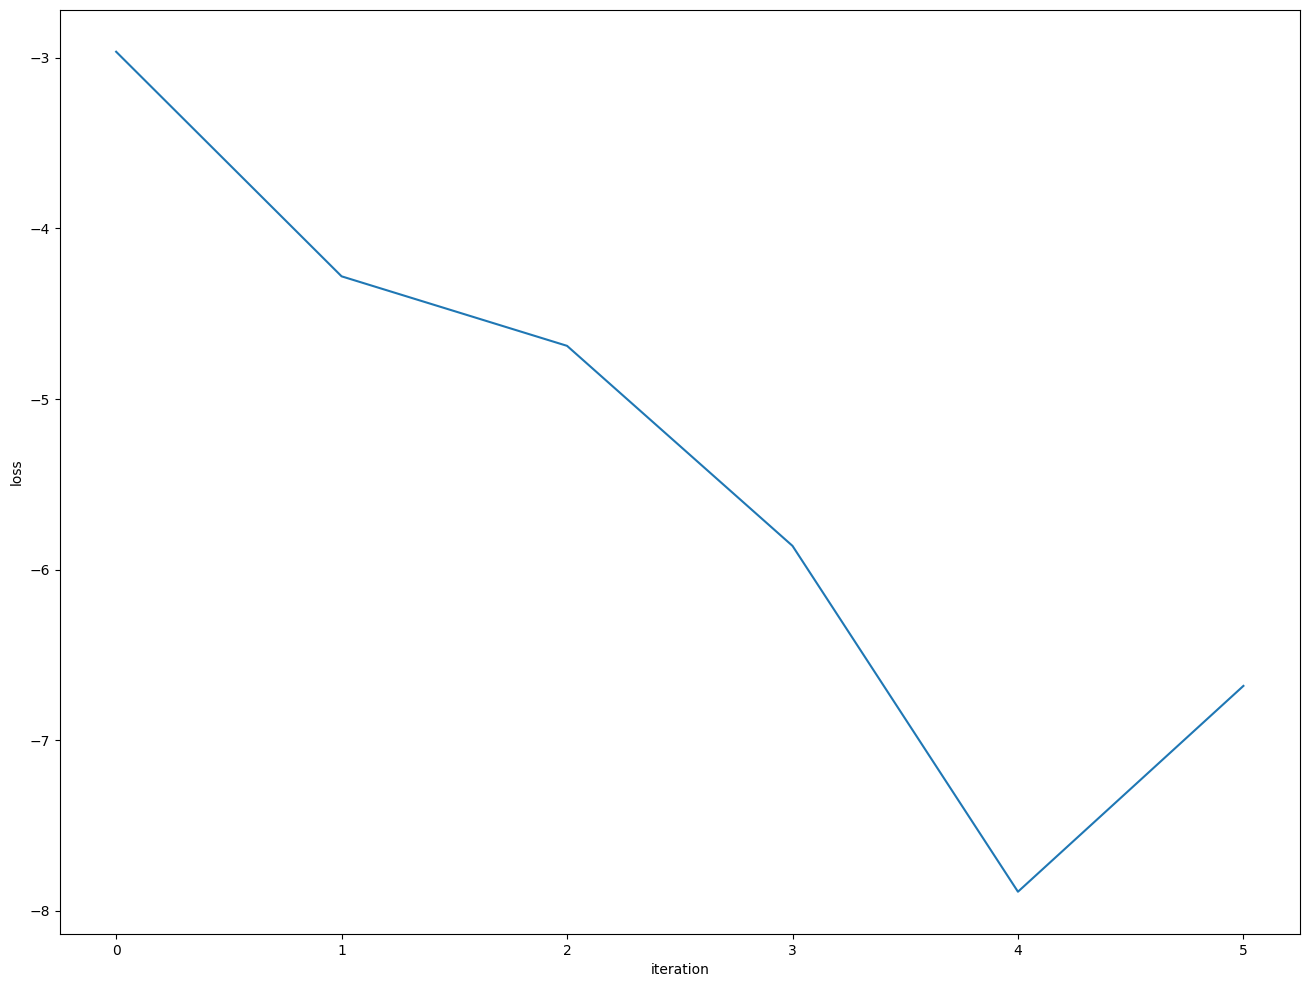

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

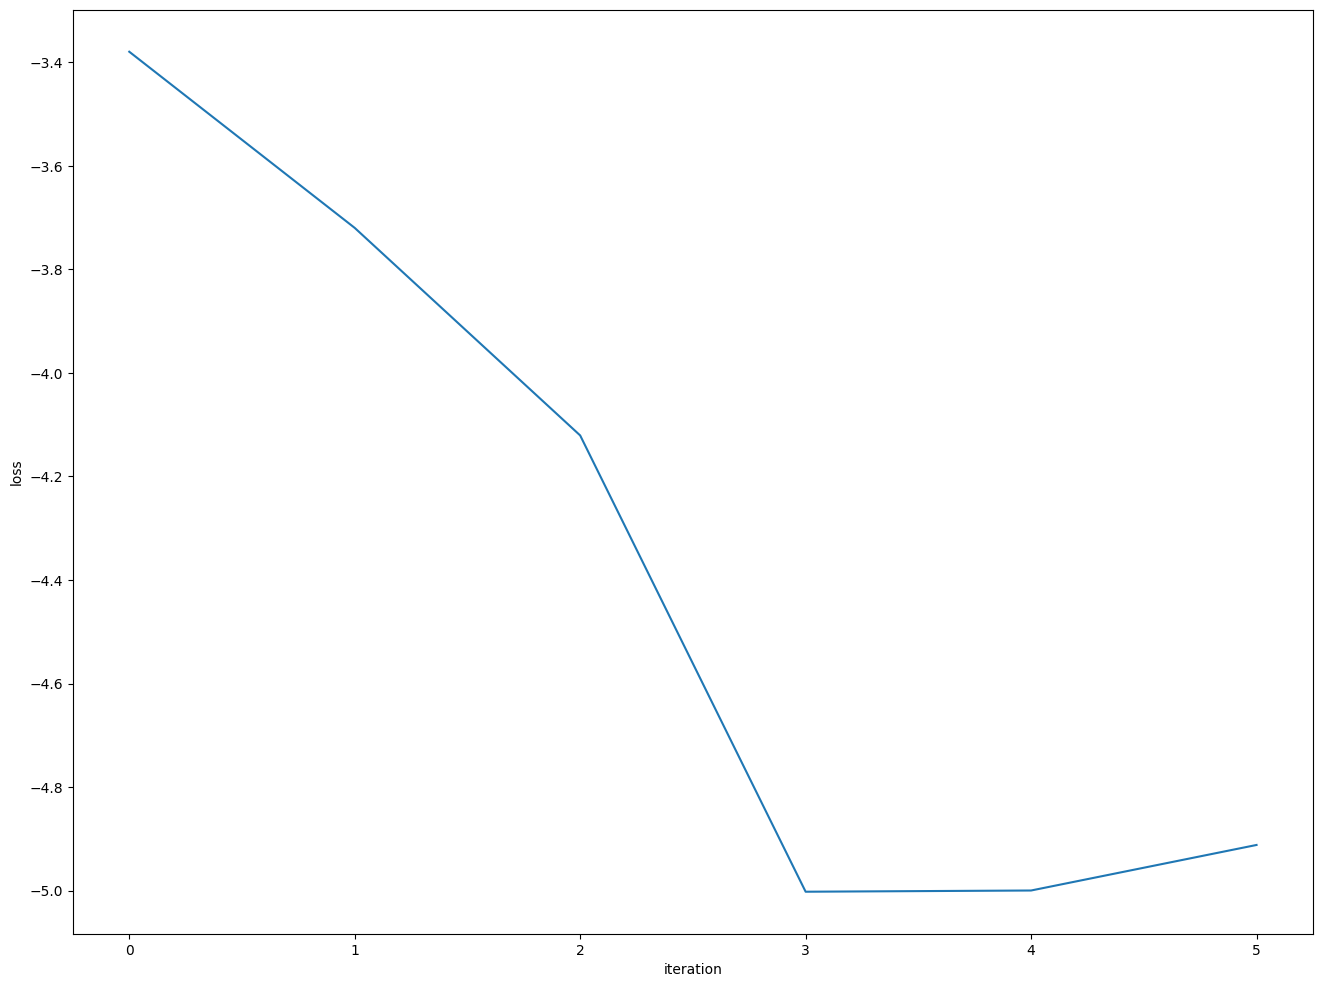

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")